In [ ]:
import numpy as np

In [ ]:

import pandas as pd
import nibabel as nib
import os
from os import listdir
from os.path import isfile, join, exists
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.distance import pdist,squareform,cosine,euclidean,mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats
from IPython.core.debugger import set_trace
from tqdm import tqdm
import time
import copy
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
from PIL import Image


from sklearn.manifold import MDS
from sklearn.linear_model import LinearRegression

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
import torchvision.datasets as datasets 

import importlib
import nnutils as utils
import rsatools as rsa

importlib.reload(utils)
importlib.reload(rsa)

In [3]:
# model hyperparameters

In [4]:
fmri_dataset = 'Cohen2017'
arch = 'alexnet' # 
imageset = 'mc8-lummatched' #
loc_imageset = 'imagefiles-fullset' # 
img_dim = 224 # 
FDR_p = 0.05 # 
rdv_dist = 'correlation' # 
batch_size = 240 #
save_as = '.npy'

save_layer_rdvs = True
overwrite = False
verbose = True

In [5]:
# modalities
modalities = ['neural','deepnet','imgstats','behavior'] # behavior too?

opts = dict()
opts['regions'] = ['FFA','PPA'] # 
if 'imagefiles' in loc_imageset:
    opts['loc_domain_idx'] = [1,3] # must correspond to the ordering of the brain regions imagefiles is 1,3. vpnl is 0,3
elif 'vpnl' in loc_imageset:
    opts['loc_domain_idx'] = [0,3]
opts['deepnet_regions'] = ['dnFA','dnPA'] # 
opts['expimg_validation_idx'] = [0,3] # faces, buildings indices in the exp dataset # 0,3 for mc8, 
opts['sel_check_method'] = 'z'
opts['selectivity_threshold'] = 2 # units of z scores above the mean of non-pref categs

opts['trainsets'] = ['object','face','scene','random']

if fmri_dataset == 'Cohen2017':
    opts['datatypes_avail'] = ['univar','rdv'] ## others to add for models: MDS. lesioning gets separate thing?
    opts['levels_avail'] = ['categ']
    opts['data_fn'] = 'RoiRsa_reordered.mat'
    opts['struct_name'] = 'R'
    opts['roi_fieldname'] = 'roiList'
    opts['univar_fieldname'] = 'roiCondMeans'
    opts['rdv_fieldname'] = 'roiRsaSubCube'
    opts['categ_strs_u'] = np.array(['faces','bodies','cats','cars','hammers','phones','chairs','buildings'])
    opts['categ_strs_m'] = opts['categ_strs_u']
    opts['plot_order'] = np.array([0,1,2,4,6,7,5,3])
    
elif fmri_dataset == 'Baker2018':
    opts['datatypes_avail'] = ['rdv']
    opts['levels_avail'] = ['categ']
    opts['data_fn'] = 'Baker.mat'
    opts['struct_name'] = 'Baker'
    opts['roi_fieldname'] = 'roiList'
    opts['univar_fieldname'] = []
    opts['rdv_fieldname'] = []
    opts['categ_strs_u'] = np.array(['faces','cats','bodies','cars','hammers','phones','chairs','buildings'])
    opts['categ_strs_m'] = ['birds', 'boats', 'body parts', 'butterflies', 'cars', 'churches', 'cityscapes', 'clothes', 'deserts""dishes', 'accessories', 
    'dolls', 'factories', 'farm animals', 'fire', 'flowers', 'food', 'forests', 'houses', 'bugs', 'adults', 'kids', 'kitchens', 'living rooms', 'masks', 
    'motorscycles', 'mountains', 'older adults', 'pets', 'airplanes', 'pools', 'roads', 'signs', 'lizards/snakes', 'spiders', 'sports', 'suburbs', 'tools', 
    'toys', 'trains', 'appliances', 'wild animals', 'gyms', 'bags', 'bathrooms', 'beaches', 'beds', 'bikes']
    opts['plot_order'] = np.arange(len(opts['categ_strs_m']))
    opts['n_reliable_categs_incl'] = 48
    
if loc_imageset == 'imagefiles-fullset':
    opts['loc_domain_list'] = ['Bodies','Faces','Objects','Scenes','Scrambled']
elif loc_imageset == 'vpnl-floc':
    opts['loc_domain_list'] = ['faces','bodies','objects','scenes','characters','scrambled']
    
if 'mc8' in imageset:
    opts['categ_idx_u'] = np.repeat(np.arange(8), 30)
    opts['categ_idx_m'] = np.repeat(np.arange(8), 30)
elif 'baker' in imageset:
    opts['categ_idx_u'] = np.repeat(np.arange(8), 30)
    opts['categ_idx_m'] = np.repeat(np.arange(48), 3)
    

In [6]:
home_dir = '/home/jacobpri/git/RotspaceIT/'

# target directory for saving activations
activation_savedir = join(home_dir,'data','d02_modeling','activations')

# target directory for saving layer-wise RDVs
rdv_savedir = join(home_dir,'data','d02_modeling','rdvs')

# folder of trained model weights
weight_dir = join(home_dir,'data','d02_modeling','weights')

# folder of fmri data
fmri_dir = join(home_dir, 'data', 'd03_processing', fmri_dataset)

# folder of image sets
imageset_dir = join(home_dir,'imagesets')

load_arch = arch + '-' + 'object'

dirs = os.listdir(imageset_dir)

found = False
for d in dirs:
    d_ = os.listdir(join(imageset_dir,d))
    if (imageset in d_):
        imageset_dir = join(imageset_dir, d, imageset)
        activation_savedir = join(activation_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        rdv_savedir = join(rdv_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        found = True
        break
    
if not exists(fmri_dir):
    raise ValueError('processed fmri data not found')

In [7]:
def fill_silent_imgs(X):

    # again, check to be sure all images evoke activation somewhere. if not, fill with tiny randoms to avoid errors
    bad_idx = np.argwhere(np.sum(X,axis=1)==0)
    if len(bad_idx) > 0:
        for ii in bad_idx:
            X[ii] = np.random.normal(0,0.000001,(1,X.shape[1]))
            
    return X


In [8]:
save_dir = join(home_dir,'data','d04_RSA','RSAModels')
os.makedirs(save_dir,exist_ok=True)

save_str = f"RSAModel_fMRI-{fmri_dataset}_arch-{arch}_locimg-{loc_imageset}_expimg-{imageset}_dim-{img_dim}_dm-{rdv_dist}_FDR-{FDR_p}_neural-{'-'.join(opts['regions'])}_deepnet-{'-'.join(opts['deepnet_regions'])}.npy"
save_fn = join(save_dir, save_str)

print(save_fn)

if exists(save_fn) and overwrite == False:
    print('RSAModel already exists. loading...')
    R = np.load(save_fn,allow_pickle=True).item()
    
else:

    # dict for al RSA variables
    R = dict()
    for mod in modalities:
        R[mod] = dict()
        
    # helper #1, get brain RDMs
    # save relevant files
    fn = join(fmri_dir,'fmri_roidata_submean.npy')
    fmri_data = np.load(fn,allow_pickle=True).item()

    for mod in modalities:
        if mod == 'neural':
            for region in opts['regions']:
                R[mod][region] = dict()

                for datatype in opts['datatypes_avail']:
                    R[mod][region][datatype] = dict()

                    for level in opts['levels_avail']:
                        R[mod][region][datatype][level] = fmri_data[region][datatype][level]
                        
                        
    # helper #2, get model RDMs
    for trainset in opts['trainsets']:

        load_arch_ = arch + '-' + trainset

        # target directory for saving layer-wise pref dicts
        prefdict_savedir = join(home_dir,'data','d02_modeling','selectivity', load_arch_, 'localizer', loc_imageset, 'dim' + str(img_dim))

        ## load preference dict for a given locset/model/param combination
        load_str = 'layer_pref_dicts_FDR_p_' + str(FDR_p).replace('.','-') + save_as
        load_fn = join(prefdict_savedir,load_str)
        if not exists(load_fn):
            print(load_fn)
            raise ValueError('pref dict does not exist')

        else:
            # load pref dict
            pref_dict = np.load(load_fn, allow_pickle=True).item()
            layers = list(pref_dict.keys())

            # for each layer...
            for layer in tqdm(layers):

                # for each selectivity domain of interest...
                for dom in range(len(opts['loc_domain_idx'])):

                    # create label for this deepnet model/layer combo
                    idx = opts['loc_domain_idx'][dom]
                    dn_reg = opts['deepnet_regions'][dom]
                    model_layer = f'{trainset}_{dn_reg}_{layer}'

                    R['deepnet'][model_layer] = dict()
                    R['deepnet'][model_layer]['univar'] = dict()
                    R['deepnet'][model_layer]['rdv'] = dict()
                    R['deepnet'][model_layer]['mds'] = dict()

                    # get indices of selective neurons
                    selective_idx = pref_dict[layer]['domain_idx'][idx]
                    print(model_layer, len(selective_idx))
                    
                    R['deepnet'][model_layer]['selective_idx'] = selective_idx
                    R['deepnet'][model_layer]['n_selective'] = len(selective_idx)
                    
                    if imageset == 'bakerboth':
                        imageset_ = 'bakerset1'
                    else:
                        imageset_ = imageset

                    # load batched activations
                    act_loaddir = join(home_dir, 'data','d02_modeling', 'activations', 
                                       load_arch_, 'experimental', imageset_, 'dim' + str(img_dim))

                    if not exists(act_loaddir):
                        print(act_loaddir)
                        raise ValueError('act dir not found')

                    # load acts and subselect selective units
                    Y_u = utils.load_batched_activations(act_loaddir, layer, batch_size)
                    Y_m = copy.deepcopy(Y_u)
                                                                   
                    R['deepnet'][model_layer]['prop_selective'] = len(selective_idx) / Y_u.shape[1]
                    
                    # goal: have Y_sel and Y_sel_, two copies. 
                    # Y_sel_u is used for all univariate things, Y_sel_m is used for all rdms
                    # in baker, Y_sel_u gets overwritten by cohen acts, Y_sel_m is the mean of 2 baker sets
                    
                    Y_sel_u = copy.deepcopy(Y_u)[:,selective_idx]
                    Y_sel_m = copy.deepcopy(Y_m)[:,selective_idx]
                    
                    # average activations from second image set
                    if 'baker' in imageset:
                        
                        if 'both' in imageset:
                            imageset2 = 'bakerset2'
                            
                             # load batched activations
                            act_loaddir2 = join(home_dir, 'data','d02_modeling', 'activations', 
                                           load_arch_, 'experimental', imageset2, 'dim' + str(img_dim))

                            # load acts and subselect selective units
                            Y_set2 = utils.load_batched_activations(act_loaddir2, layer, batch_size)
                            Y_set2_sel = copy.deepcopy(Y_set2)[:,selective_idx]

                            # whole layer acts are mean of 2 image sets
                            Y_m = np.nanmean(np.stack([Y_m, Y_set2],axis=2),axis=2)

                            # selective subset acts are mean of 2 image sets
                            Y_sel_m = np.nanmean(np.stack([Y_sel_m, Y_set2_sel],axis=2),axis=2)
                        
                        act_loaddir3 = join(home_dir, 'data','d02_modeling', 'activations', 
                                       load_arch_, 'experimental', 'mc8-lummatched', 'dim' + str(img_dim))
                        
                        # replace univariate acts with cohen ones -> todo, remove this and just save+load validity info
                        Y_ = utils.load_batched_activations(act_loaddir3, layer, batch_size)
                        Y_u = copy.deepcopy(Y_)
                        Y_sel_u = copy.deepcopy(Y_u)[:,selective_idx]
                    
                    # again, check to be sure all images evoke activation somewhere. if not, fill with tiny randoms to avoid errors
                    Y_sel_u = fill_silent_imgs(Y_sel_u)
                    Y_sel_m = fill_silent_imgs(Y_sel_m)

                    # if there are at least 2 selective units, compute means and rdvs
                    if Y_sel_u.shape[1] > 1:
                        R['deepnet'][model_layer]['univar']['item'] = rsa.univar_mean(Y_sel_u)
                        R['deepnet'][model_layer]['univar']['categ'] = rsa.univar_mean(rsa.collapse_categs(Y_sel_u,opts['categ_idx_u']))
                        
                        #print(R['deepnet'][model_layer]['univar']['categ'])
                        
                        R['deepnet'][model_layer]['rdv']['item'] = rsa.rdv(Y_sel_m, rdv_dist)
                        R['deepnet'][model_layer]['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(Y_sel_m,opts['categ_idx_m']), rdv_dist)

                        # if there are no categories that have 0 activations for all imgs, perform MDS
                        if np.sum(R['deepnet'][model_layer]['univar']['categ'] == 0) == 0:
                            try:
                                embedding = MDS(n_components=2,dissimilarity='precomputed',random_state=365)
                                mds_coords = embedding.fit_transform(rsa.v2m(R['deepnet'][model_layer]['rdv']['item']))
                                R['deepnet'][model_layer]['mds']['item'] = mds_coords
                            except:
                                print('warning: subset MDS failed', model_layer)
                                R['deepnet'][model_layer]['mds']['item'] = np.nan
                        else:
                            print('skipping MDS for ', model_layer)
                            R['deepnet'][model_layer]['mds']['item'] = rsa.nan_matrix((Y_sel_m.shape[0],2))

                    # else, no selective subset, fill everything with nans    
                    else:
                        print(f'fewer than 2 selective units in {model_layer}')
                        R['deepnet'][model_layer]['univar']['item'] = rsa.nan_matrix((Y_sel_u.shape[0],))
                        R['deepnet'][model_layer]['univar']['categ'] = rsa.nan_matrix((len(opts['categ_strs_u']),))

                        R['deepnet'][model_layer]['rdv']['item'] = rsa.nan_matrix((len(rsa.rdv(np.random.normal(0,1,(Y_sel_m.shape[0],2)))),))
                        R['deepnet'][model_layer]['rdv']['categ'] = rsa.nan_matrix((len(rsa.rdv(np.random.normal(0,1,(len(opts['categ_strs_m']),2))))),)

                        R['deepnet'][model_layer]['mds']['item'] = rsa.nan_matrix((Y_sel_m.shape[0],2))


                    # once we're done with the selective subsets, compute means/rdvs/MDS at the whole layer level 
                    if dom == len(opts['loc_domain_idx']) - 1:
                        model_layer = f'{trainset}_layer_{layer}'

                        # again, check to be sure all images evoke activation somewhere. if not, fill with tiny randoms to avoid errors
                        Y_u = fill_silent_imgs(Y_u)
                        Y_m = fill_silent_imgs(Y_m)
                                
                        R['deepnet'][model_layer] = dict()
                        R['deepnet'][model_layer]['univar'] = dict()
                        R['deepnet'][model_layer]['univar']['item'] = rsa.univar_mean(Y_u)
                        R['deepnet'][model_layer]['univar']['categ'] = rsa.univar_mean(rsa.collapse_categs(Y_u,opts['categ_idx_u']))

                        R['deepnet'][model_layer]['rdv'] = dict()
                        R['deepnet'][model_layer]['mds'] = dict()

                        # load precomputed rdv if it exists
                        rdv_loaddir = join(home_dir, 'data','d02_modeling', 'rdvs', 
                                       load_arch_, 'experimental', imageset_, 'dim' + str(img_dim))

                        fn = join(rdv_loaddir,f'{layer}_rdv_dist_{rdv_dist}.npy')

                        if exists(fn):
                            rdv = np.load(fn)
                            R['deepnet'][model_layer]['rdv']['item'] = rdv

                        # if not, compute it here
                        else:
                            print('rdv not yet saved')
                            print('computing item-level rdv using all layer neurons...')
                            print('dim = ', Y_m.shape)
                            R['deepnet'][model_layer]['rdv']['item'] = rsa.rdv(Y_m, rdv_dist)

                        R['deepnet'][model_layer]['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(Y_m,opts['categ_idx_m']), rdv_dist)

                        # if there are no categories that have 0 activations for all imgs, perform MDS
                        if np.sum(R['deepnet'][model_layer]['univar']['categ'] == 0) == 0:
                            try:
                                embedding = MDS(n_components=2,dissimilarity='precomputed',random_state=365)
                                mds_coords = embedding.fit_transform(rsa.v2m(R['deepnet'][model_layer]['rdv']['item']))
                                R['deepnet'][model_layer]['mds']['item'] = mds_coords
                            except:
                                print('warning: layer MDS failed..', model_layer)
                                R['deepnet'][model_layer]['mds']['item'] = np.nan
                        else:
                            R['deepnet'][model_layer]['mds']['item'] = rsa.nan_matrix((Y_m.shape[0],2))


    # directory for loading low-level image stat data
    gist_savedir = join(home_dir,'data','d02_modeling','gist', 'experimental', imageset_)

    load_strs = ['GistPCFeatures.mat','GaborFeatures.mat']

    R['imgstats']['gistPC'] = dict()
    R['imgstats']['gistPC']['rdv'] = dict()
    R['imgstats']['gabor'] = dict()
    R['imgstats']['gabor']['rdv'] = dict()

    for load_str in load_strs:

        load_fn = join(gist_savedir,load_str)
        if not exists(load_fn):
            print(load_fn)
            raise ValueError('feature file does not exist')

        else:
            features = sio.loadmat(load_fn)[load_str.split('.')[0]]
            
            if 'bakerboth' in imageset:
                gist_savedir = join(home_dir,'data','d02_modeling','gist', 'experimental', 'bakerset2')
                load_fn = join(gist_savedir,load_str)
                if not exists(load_fn):
                    print(load_fn)
                    raise ValueError('feature file does not exist')

                else:
                    features_set2 = sio.loadmat(load_fn)[load_str.split('.')[0]]
                    
                features = np.nanmean(np.stack([features, features_set2],axis=2),axis=2)

            if 'gist' in load_str.lower():
                R['imgstats']['gistPC']['rdv']['item'] = rsa.rdv(features, rdv_dist)
                R['imgstats']['gistPC']['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(features, opts['categ_idx_m']), rdv_dist)
            elif 'gabor' in load_str.lower():
                R['imgstats']['gabor']['rdv']['item'] = rsa.rdv(features, rdv_dist)
                R['imgstats']['gabor']['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(features, opts['categ_idx_m']), rdv_dist)


    # TODO: add baker behavioral data
    # directory for loading behavioral data
    behav_loaddir = join(home_dir,'data','d01_rawdata',fmri_dataset)

    load_str = 'SearchRT_reordered.mat'

    load_fn = join(behav_loaddir,load_str)
    
    if not exists(load_fn):
        print(load_fn)
        print('behavioral data does not exist, skipping...')
        R['behavior']['search_rts'] = rsa.nan_matrix((len(rsa.rdv(np.random.normal(0,1,(len(opts['categ_strs_m']),2))))),)
    else:
        rts = sio.loadmat(load_fn)['SearchRT']
        R['behavior']['search_rts'] = rts

    R['layers'] = layers
    
    np.save(save_fn, R)



/home/jacobpri/git/RotspaceIT/data/d04_RSA/RSAModels/RSAModel_fMRI-Cohen2017_arch-alexnet_locimg-imagefiles-fullset_expimg-mc8-lummatched_dim-224_dm-correlation_FDR-0.05_neural-FFA-PPA_deepnet-dnFA-dnPA.npy
RSAModel already exists. loading...


In [9]:
def check_valid_selectivity(univar, idx, threshold = 2, verbose = False, method = 'z'):
    
    #if np.sum(np.isnan(univar)) > 0:
    #    print('warning: input contains %d nans' % (np.sum(np.isnan(univar))))
        
    assert(np.ndim(univar) == 1)
    if method == 'z':  
        non_pref_mean = np.nanmean(univar[np.arange(len(univar))!=idx])
        non_pref_std = np.nanstd(univar[np.arange(len(univar))!=idx])

        pref_z = (univar[idx]  - non_pref_mean) / non_pref_std

        if verbose is True:
            print(f'value of {univar[idx]} at idx {idx}')
            print(f'selectivity is {round(pref_z,3)} stds (std={round(non_pref_std,3)}) from the mean of other categs (mean={round(non_pref_mean,3)}))')
        if np.logical_or(np.isnan(pref_z), pref_z < threshold):
            return -1
        else:
            return 1
    
    elif method == 'max':
        if univar[idx] == np.nanmax(univar):
            return 1
        else:
            return -1
    
def partition_variance(predictors, target):
    nP = len(predictors)
    
    # full model
    full_mdl = LinearRegression()
    full_mdl.fit(np.stack(predictors,axis=1),target)
    full_mdl_R2 = full_mdl.score(np.stack(predictors,axis=1),target)
    print('full model R2: ', round(full_mdl_R2,4))
    
    non_explained = 1 - full_mdl_R2
    
    mdl_R2s = []
    unique_vars_expl = []
    
    shared = 1 - non_explained
    for i in range(nP):
        mdl = LinearRegression()
        mdl.fit(np.stack(predictors[:i] + predictors[i+1:],axis=1), target)
        mdl_R2s.append(mdl.score(np.stack(predictors[:i] + predictors[i+1:],axis=1), target))
        unique_vars_expl.append(full_mdl_R2 - mdl_R2s[-1])
        print('model without predictor ' + str(i) + ' has R2: ' + str(round(mdl_R2s[-1],4)))
        
        print('unique variance explained by predictor ' + str(i) + ' is ' + str(round(unique_vars_expl[-1],4)))
        print('\n')
        
        shared -= unique_vars_expl[-1]
        
    print('shared variance is ', round(shared,4))
    print('non-explained variance is ', round(non_explained,4))
    
    return full_mdl_R2, unique_vars_expl, shared, non_explained


In [33]:
lay_keys = list(R['deepnet'].keys())

layers = []
all_layers = []

for key in lay_keys:
    all_layers.append('_'.join(key.split('_')[2:]))
    if 'relu' in key:
        layers.append('_'.join(key.split('_')[2:]))
        
#print(layers)
    
_, idx = np.unique(layers, return_index=True)
layers = np.array(layers)[np.sort(idx)]

dn_models = opts['deepnet_regions'] + ['layer']
imgstat_models = list(R['imgstats'].keys())

########

corrs = dict()
corrs['behavior'] = dict()

validity = dict()
reliability = dict()

# corrs['brain region']['trainset_region'] = list of layers
# validity['brain region']['trainset_region'] = list of layers (logical)

i = 0
for brain_roi in opts['regions']:
    
    corrs[brain_roi] = dict()
    validity[brain_roi] = dict()
    
    if 'baker' in imageset:
        
        load_str = f'Baker_Reliability_CategRankings_{brain_roi}.mat'
        load_fn = join(join(home_dir,'data','d01_rawdata',fmri_dataset),load_str)

        reliability[brain_roi] = sio.loadmat(load_fn)[f'Baker_Reliability_CategRankings_{brain_roi}']
        
        incl_idx = reliability[brain_roi][:opts['n_reliable_categs_incl']]
    else:
        incl_idx = np.arange(len(opts['categ_strs_m']))
    
    for trainset in opts['trainsets']:
    
        for model in dn_models:
            
            corrs[brain_roi][f'{trainset}_{model}'] = []
            corrs['behavior'][f'{trainset}_{model}'] = []
            
            validity[brain_roi][f'{trainset}_{model}'] = dict()
            validity[brain_roi][f'{trainset}_{model}']['isvalid'] = []
            
            for layer in layers:
                
                if np.sum(np.isnan(R['deepnet'][f'{trainset}_{model}_{layer}']['rdv']['categ'])) == 0:
                    # step 1: correlate all layers of all (relevant) models with brain data
                    corrs[brain_roi][f'{trainset}_{model}'].append(rsa.rdvcorr(rsa.subsample_dm(R['neural'][brain_roi]['rdv']['categ'], incl_idx),
                                                                               rsa.subsample_dm(R['deepnet'][f'{trainset}_{model}_{layer}']['rdv']['categ'], incl_idx),
                                                                               rdv_dist))
                    if 'mc8' in imageset:
                        corrs['behavior'][f'{trainset}_{model}'].append(rsa.rdvcorr(rsa.subsample_dm(R['behavior']['search_rts'], incl_idx),
                                                                    rsa.rsm2rdm(rsa.subsample_dm(R['deepnet'][f'{trainset}_{model}_{layer}']['rdv']['categ'], incl_idx)),
                                                                    rdv_dist))
                else:                                                    # need to flip behavior to similarity values because dissimilar -> faster responses
                    corrs[brain_roi][f'{trainset}_{model}'].append(np.nan)
                    corrs['behavior'][f'{trainset}_{model}'].append(np.nan)
                    
                # step 2: determine which model/layer combos are valid
                univar_means = R['deepnet'][f'{trainset}_{model}_{layer}']['univar']['categ']
                is_valid = check_valid_selectivity(univar_means, 
                                                   opts['expimg_validation_idx'][i], # which index has the preferred categ?
                                                   opts['selectivity_threshold'], # how selective must the response be?
                                                   method = opts['sel_check_method'])
                #print(model, layer, is_valid, univar_means)
                validity[brain_roi][f'{trainset}_{model}']['isvalid'].append(is_valid)
            
            # step 3: among valid models, find layers that have the best correlation
            layer_corrs = copy.deepcopy(np.array(corrs[brain_roi][f'{trainset}_{model}']))
            layer_corrs[np.array(validity[brain_roi][f'{trainset}_{model}']['isvalid']) == -1] = -10 # arbitrary negative number below the min of corrs 
            
            if np.all(layer_corrs == -10):
                best_layer_idx = np.nan
                validity[brain_roi][f'{trainset}_{model}']['maxidx'] = (np.nan, np.nan)
            else:
                best_layer_idx = np.argmax(layer_corrs)           
                validity[brain_roi][f'{trainset}_{model}']['maxidx'] = (best_layer_idx, layer_corrs[best_layer_idx])
            
            
    for imgstat_model in imgstat_models:
        corrs[brain_roi][imgstat_model] = rsa.rdvcorr(rsa.subsample_dm(R['neural'][brain_roi]['rdv']['categ'], incl_idx),
                                                      rsa.subsample_dm(R['imgstats'][imgstat_model]['rdv']['categ'], incl_idx),
                                                      rdv_dist)
        
    if 'mc8' in imageset:
        corrs[brain_roi]['behavor'] = rsa.rdvcorr(rsa.rsm2rdm(rsa.subsample_dm(R['neural'][brain_roi]['rdv']['categ'], incl_idx)),
                                               R['behavior']['search_rts'],
                                               rdv_dist)
    else:
        corrs[brain_roi]['behavior'] = np.nan
    
    
    # step 4: run variance partition to explain FFA and PPA RDMs
    # models to include:
    # best object dnFA/dnPA layer that is valid
    # best object whole layer that is valid
    # best face/scene layer that is valid
    # best face/scene dnFA/dnPA that is valid
    # best random layer that is valid
    # best random dnFA/dnPA that is valid
    # gist
    # gabor
    
    target = R['neural'][brain_roi]['rdv']['categ']
    predictors = []
    predictor_strs = []
    
    dn_region = opts['deepnet_regions'][i]
    
    for trainset in opts['trainsets']:
        for model in dn_models:
            
            if np.logical_not(np.logical_or('face' in trainset and 'PA' in brain_roi, 
                                            'scene' in trainset and 'FA' in brain_roi)) and np.logical_not('object' in trainset and 'layer' in model):
                
                best_idx, best_corr = validity[brain_roi][f'{trainset}_{model}']['maxidx']
                
                if np.logical_not(np.isnan(best_idx)) and np.logical_or(model == 'layer', dn_region in model):
                    
                    model_layer = f'{trainset}_{model}_{layers[best_idx]}'
                    rdv = R['deepnet'][model_layer]['rdv']['categ']
                    print(model_layer,best_corr)
                    
                    predictors.append(rdv)
                    predictor_strs.append(model_layer)
                    
    for imgstat in list(R['imgstats'].keys()):
        predictors.append(R['imgstats'][imgstat]['rdv']['categ'])
        predictor_strs.append(imgstat)
    print(predictor_strs)
        
    full_mdl_R2, unique_vars_expl, shared, non_explained = partition_variance(predictors, target)  
    
    corrs[brain_roi]['varpartition'] = dict()
    corrs[brain_roi]['varpartition']['full_R2'] = full_mdl_R2
    corrs[brain_roi]['varpartition']['unique'] = unique_vars_expl
    corrs[brain_roi]['varpartition']['shared'] = shared
    corrs[brain_roi]['varpartition']['non_explained'] = non_explained
    corrs[brain_roi]['varpartition']['predictors'] = predictors
    corrs[brain_roi]['varpartition']['predictor_strs'] = predictor_strs
    
    i+=1



object_dnFA_17_relu6 0.8382124899031959
face_dnFA_17_relu6 0.6376502925689747
face_layer_17_relu6 0.6224842339883844
['object_dnFA_17_relu6', 'face_dnFA_17_relu6', 'face_layer_17_relu6', 'gistPC', 'gabor']
full model R2:  0.8343
model without predictor 0 has R2: 0.5122
unique variance explained by predictor 0 is 0.3221


model without predictor 1 has R2: 0.8291
unique variance explained by predictor 1 is 0.0052


model without predictor 2 has R2: 0.8289
unique variance explained by predictor 2 is 0.0055


model without predictor 3 has R2: 0.828
unique variance explained by predictor 3 is 0.0064


model without predictor 4 has R2: 0.8333
unique variance explained by predictor 4 is 0.0011


shared variance is  0.4941
non-explained variance is  0.1657
object_dnPA_20_relu7 0.6435247626921676
scene_dnPA_17_relu6 0.4480262969231927
scene_layer_12_relu5 0.3819000835022964
random_dnPA_2_relu1 0.23474340402627955
random_layer_2_relu1 0.169733000500827
['object_dnPA_20_relu7', 'scene_dnPA_17_rel

In [34]:
#plotting helpers

def plot_RDM(rdv, plot_order = opts['plot_order'], maxval = 1.5):

    mat = rsa.v2m(rdv)
    i = np.diag_indices(mat.shape[0])
    mat[i] = 0
    #if dataset == 'Cohen2017':
    mat = mat[plot_order]
    mat = mat[:,plot_order]
    vals = mat[:]
    
    minv = np.min(vals[vals!=0])-0.025
    maxv = np.min([np.max(vals[vals!=0]+0.025), maxval])

    triu = np.triu_indices(mat.shape[0])
    data = mat

    masked_array = np.ma.masked_where(np.triu(mat), data)

    cmap = plt.cm.viridis  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    plt.imshow(masked_array, cmap=cmap, clim=(minv,maxv))
    plt.axis('off')
    #plt.colorbar()



In [35]:
categ_colors = np.array([[0.988235294117647, 0.172549019607843, 0.345098039215686],
[0.988235294117647, 0.305882352941177, 0.670588235294118],
[0.658823529411765, 0.262745098039216, 0.984313725490196],
[0.219607843137255, 0.188235294117647, 0.980392156862745],
[0.423529411764706, 0.666666666666667, 0.988235294117647],
[0.184313725490196, 0.901960784313726, 1],
[0.992156862745098, 0.576470588235294, 0.149019607843137],
[0.996078431372549, 0.909803921568627, 0.227450980392157]])

In [36]:
# plot 1: brain region univariate + RDMs

FFA


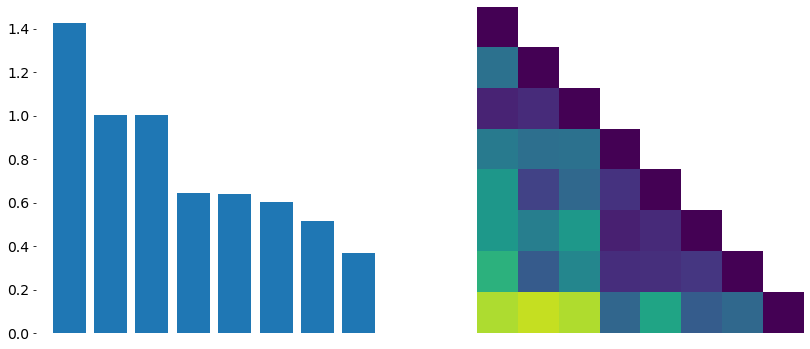

PPA


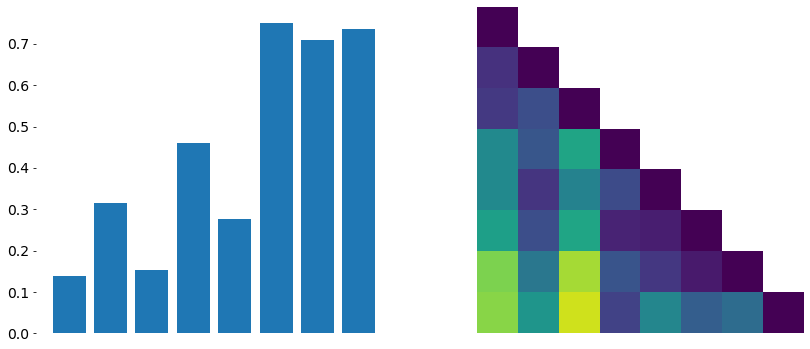

In [37]:
plt.rcParams.update({'font.size': 14})
#sns.set_style("whitegrid")

for roi in opts['regions']:
    
    print(roi)
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    
    try:
        univar = R['neural'][roi]['univar']['categ']
        plt.bar(np.arange(len(univar)), univar[opts['plot_order']])
        #sns.barplot(np.arange(len(univar)), univar[opts['plot_order']],palette=categ_colors[opts['plot_order']],alpha=0.85)
        plt.box(False)
        plt.xticks([])
    except:
        pass
    
    rdv = R['neural'][roi]['rdv']['categ']
    plt.subplot(122)
    plot_RDM(rdv)
    
    plt.show()
   

In [38]:
# plot 2: model univariate + RDMs 

object_dnFA_17_relu6


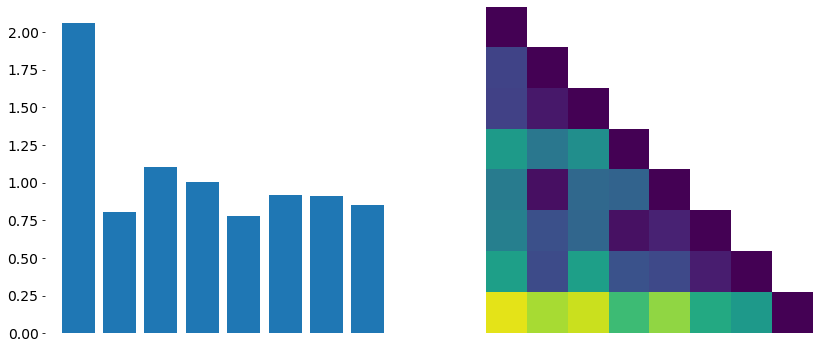

face_dnFA_17_relu6


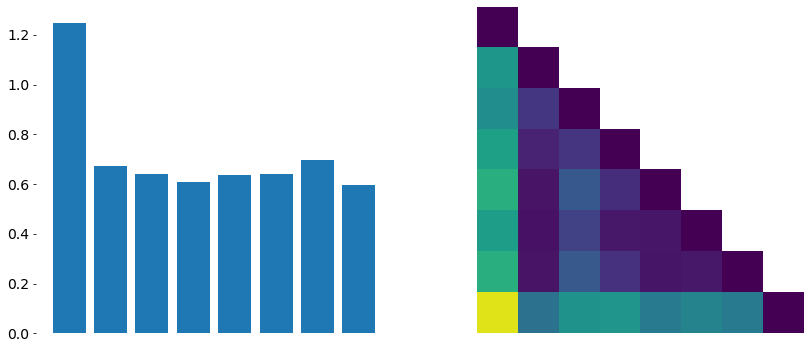

face_layer_17_relu6


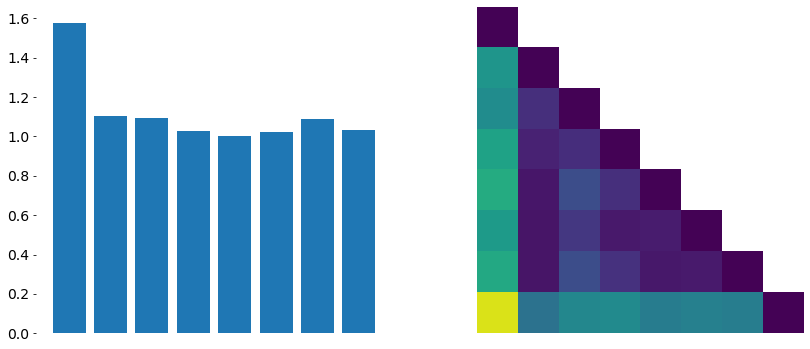

gistPC


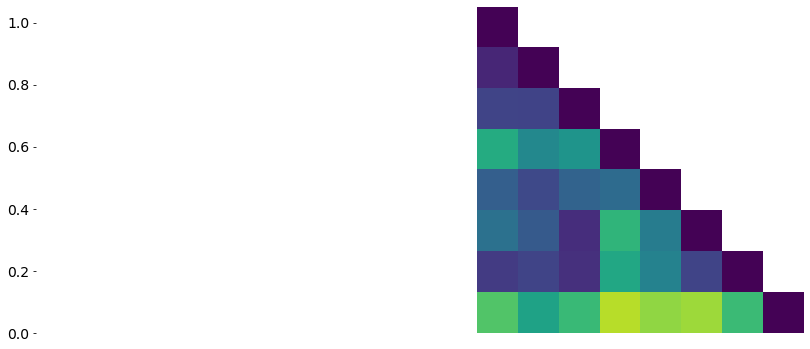

gabor


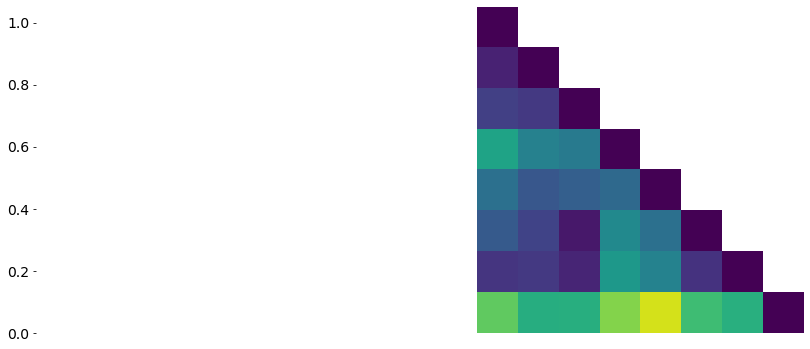

object_dnPA_20_relu7


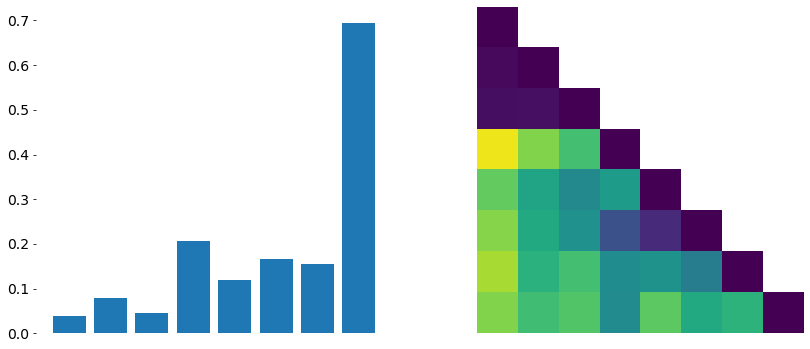

scene_dnPA_17_relu6


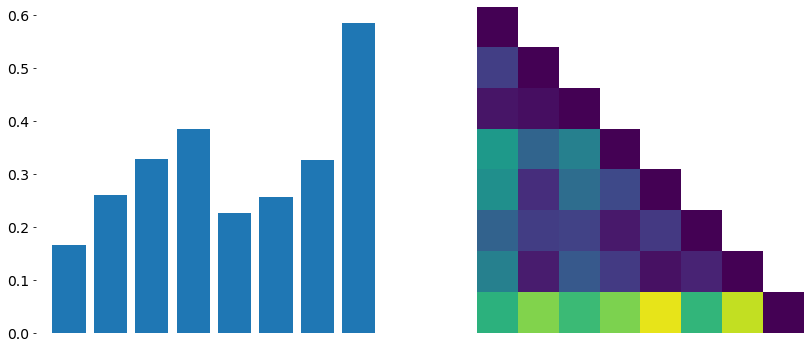

scene_layer_12_relu5


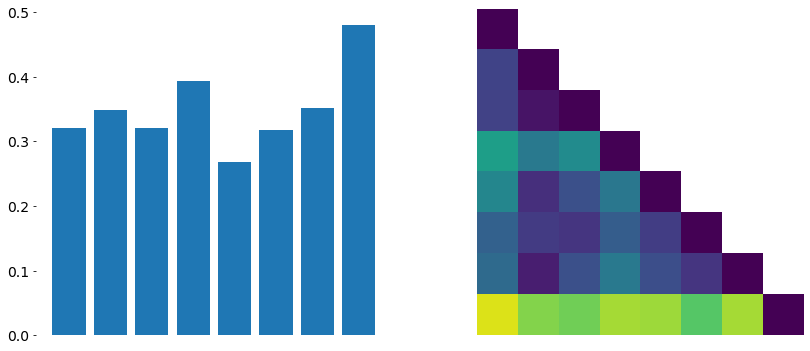

random_dnPA_2_relu1


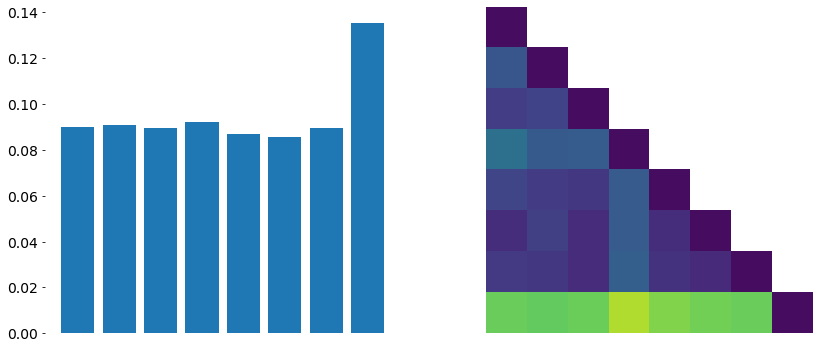

random_layer_2_relu1


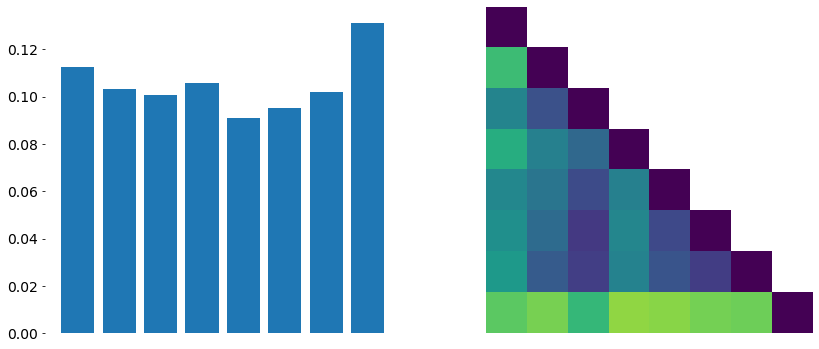

gistPC


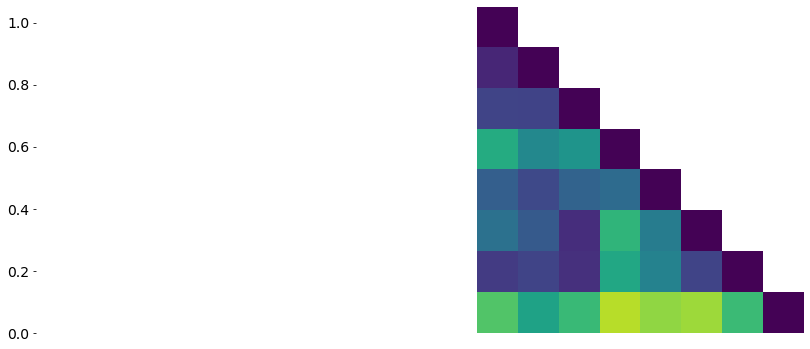

gabor


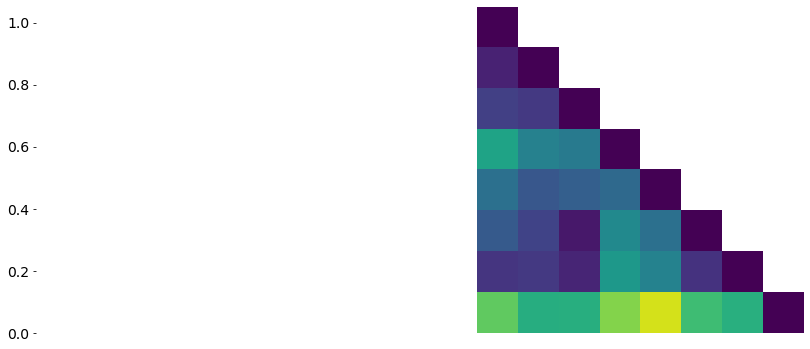

In [39]:
plt.rcParams.update({'font.size': 14})

for roi in opts['regions']:
    
    modality = 'deepnet'
    for mdl in corrs[roi]['varpartition']['predictor_strs']:
        if 'gist' in mdl:
            modality = 'imgstats'
        print(mdl)
        try:
            univar = R['deepnet'][mdl]['univar']['categ']
        except:
            univar = np.empty((len(univar),))
            univar[:] = np.nan
            
        rdv = R[modality][mdl]['rdv']['categ']

        plt.figure(figsize=(14,6))
        plt.subplot(121)
        try:
            plt.bar(np.arange(len(univar)), univar[opts['plot_order']])
            #sns.barplot(np.arange(len(univar)), univar[opts['plot_order']],palette=categ_colors[opts['plot_order']],alpha=0.85)
            plt.box(False)
            plt.xticks([])
        except:
            pass

        plt.subplot(122)
        plot_RDM(rdv)

        plt.show()

object_dnFA_17_relu6


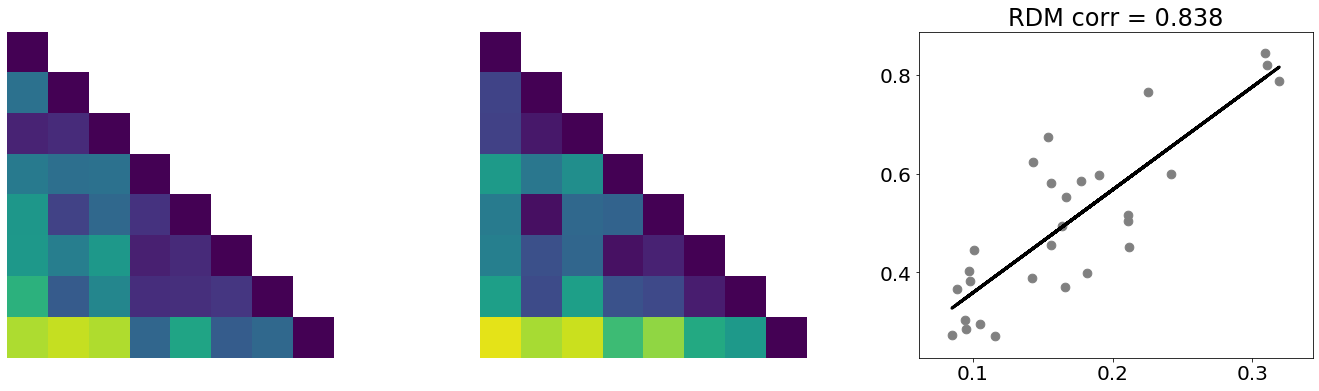

face_dnFA_17_relu6


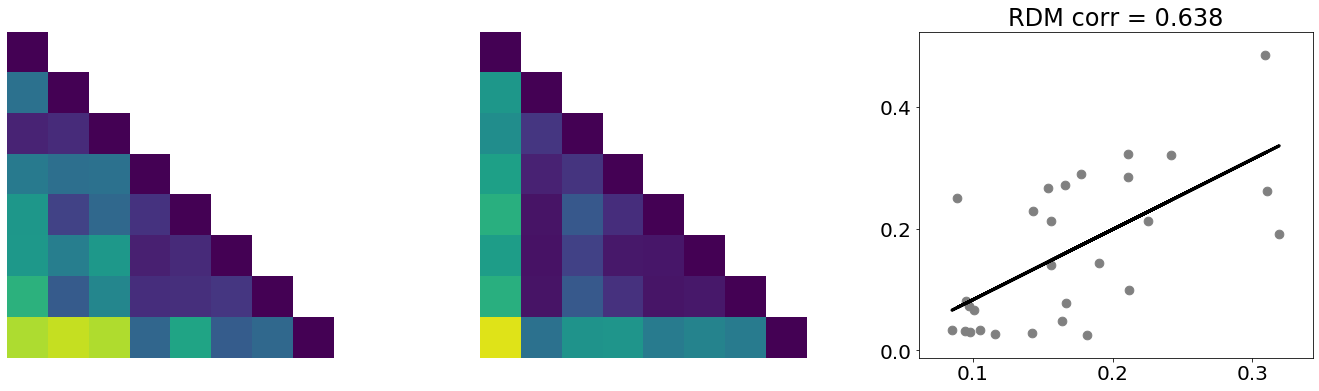

face_layer_17_relu6


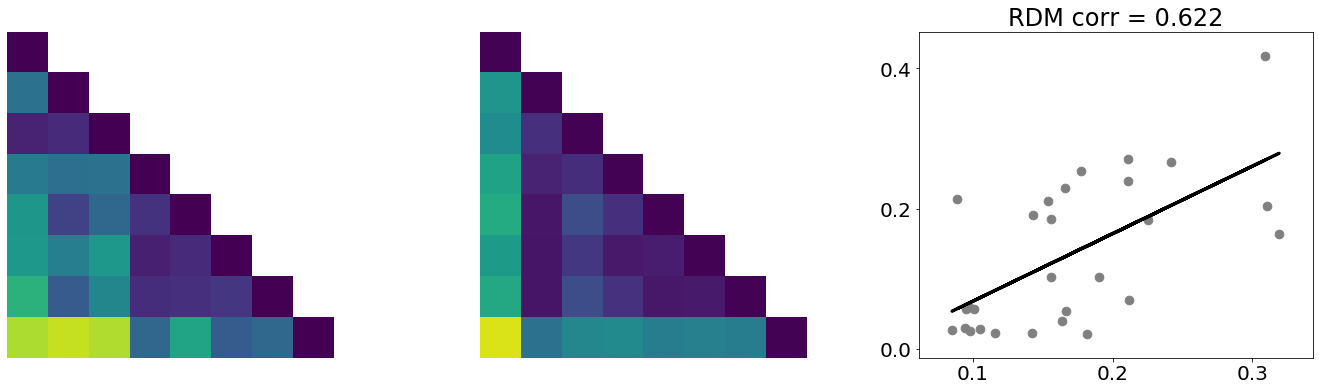

gistPC


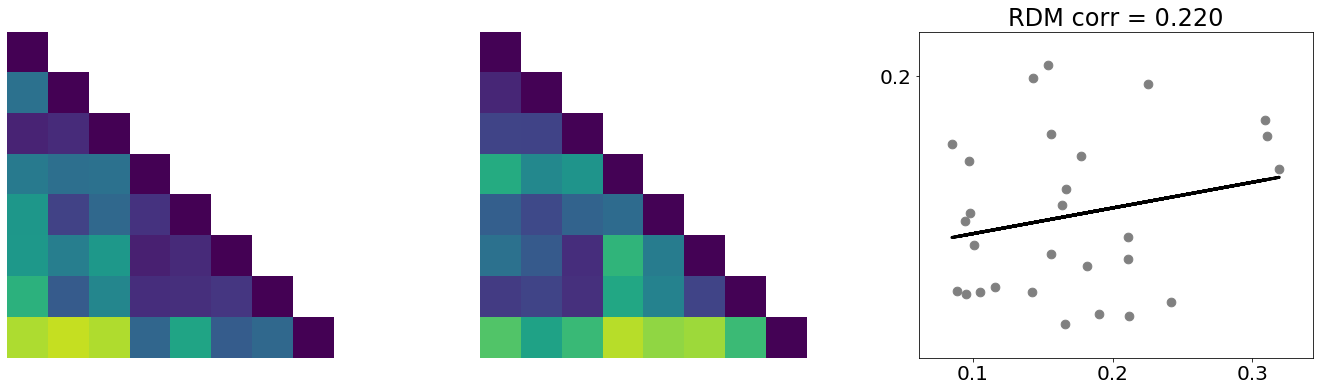

gabor


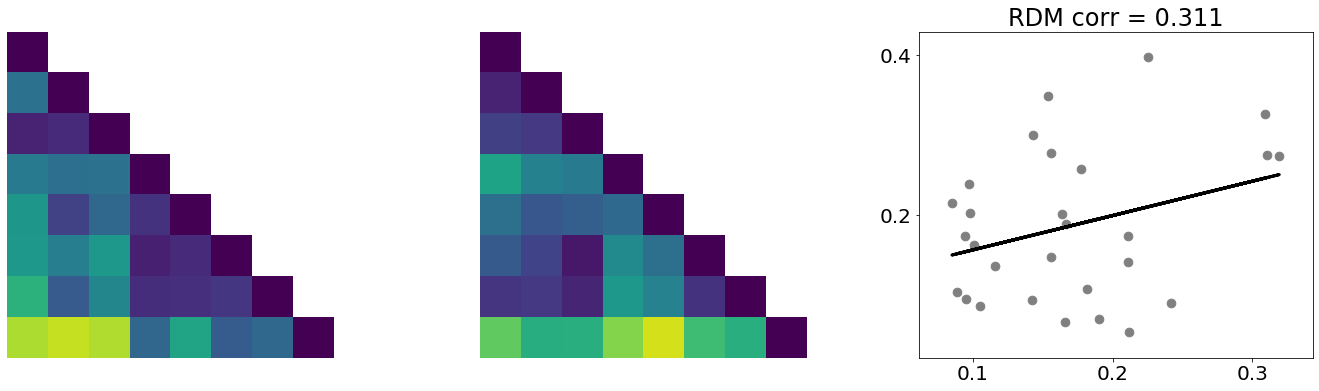

object_dnPA_20_relu7


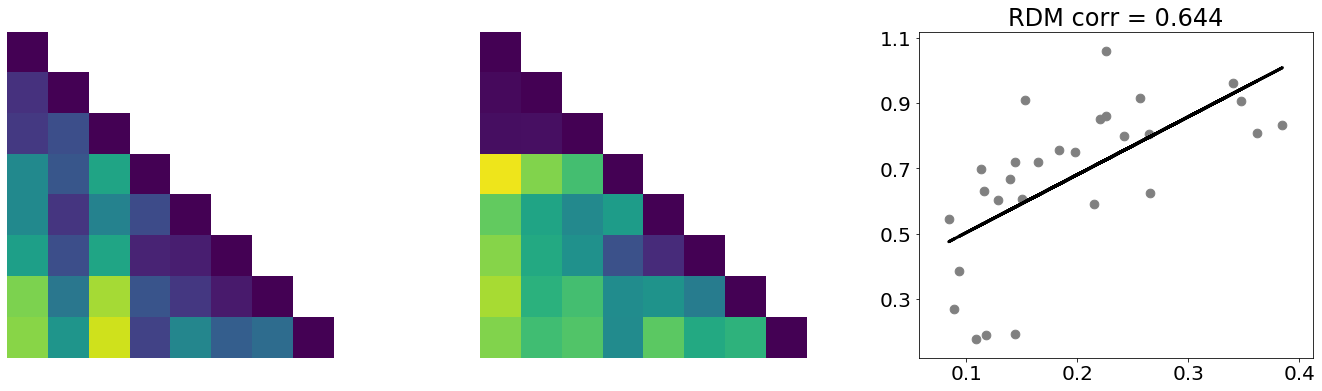

scene_dnPA_17_relu6


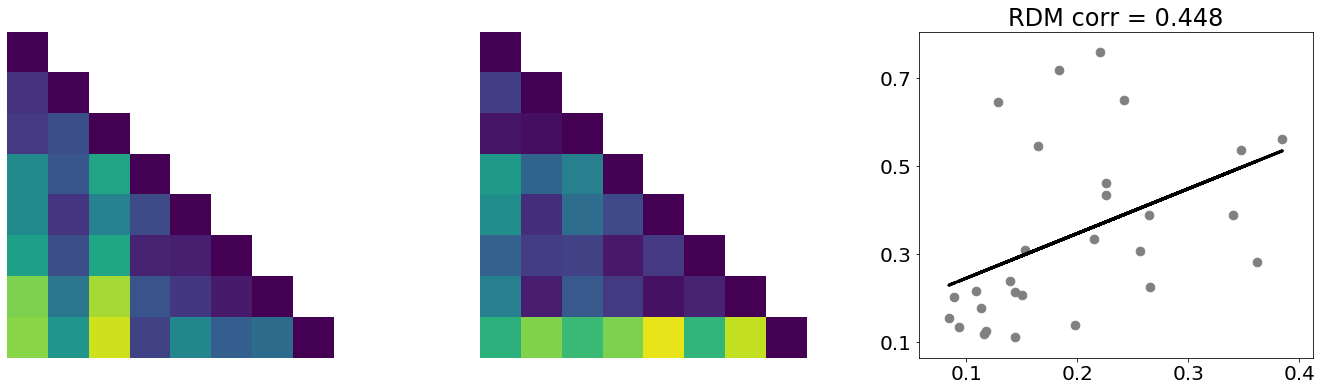

scene_layer_12_relu5


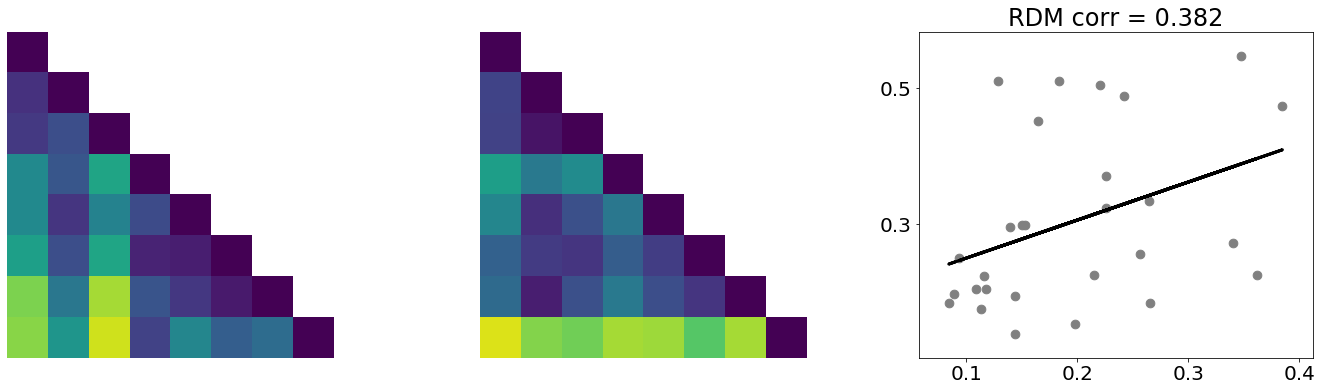

random_dnPA_2_relu1


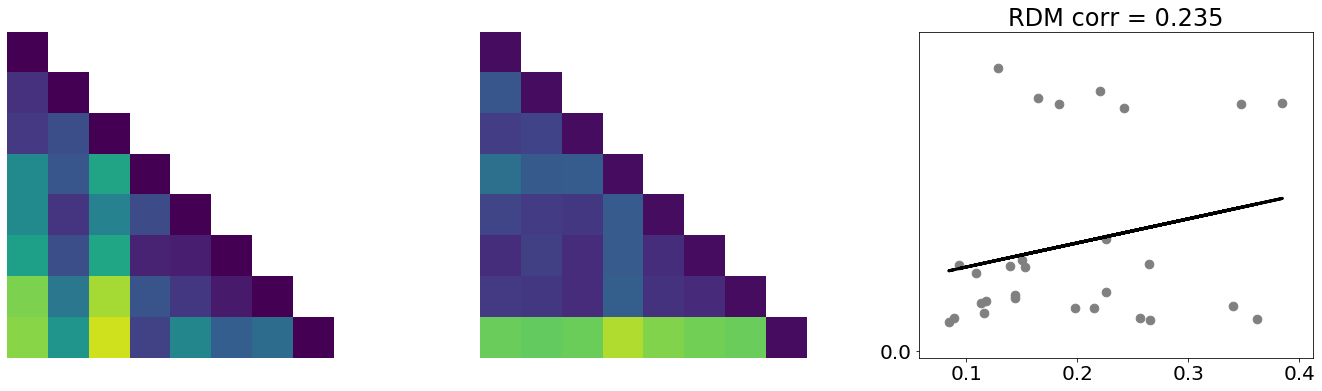

random_layer_2_relu1


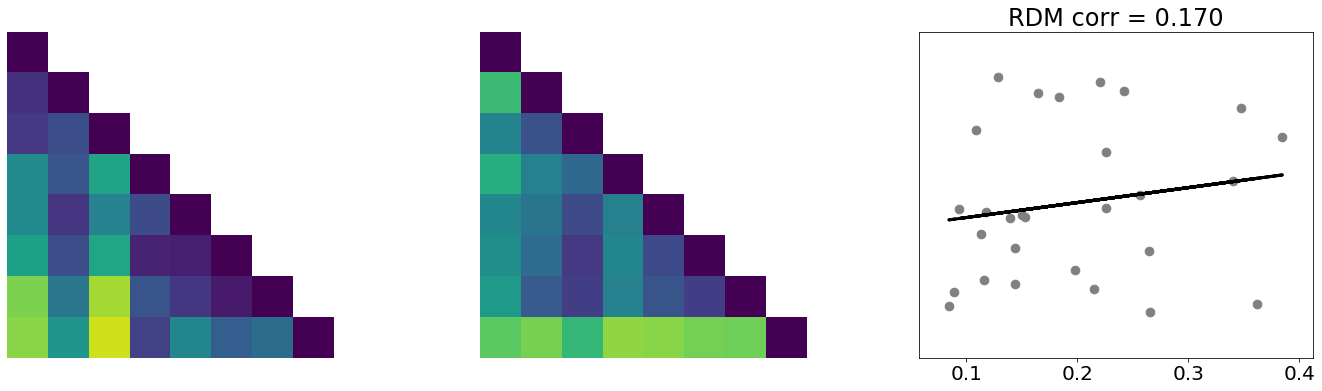

gistPC


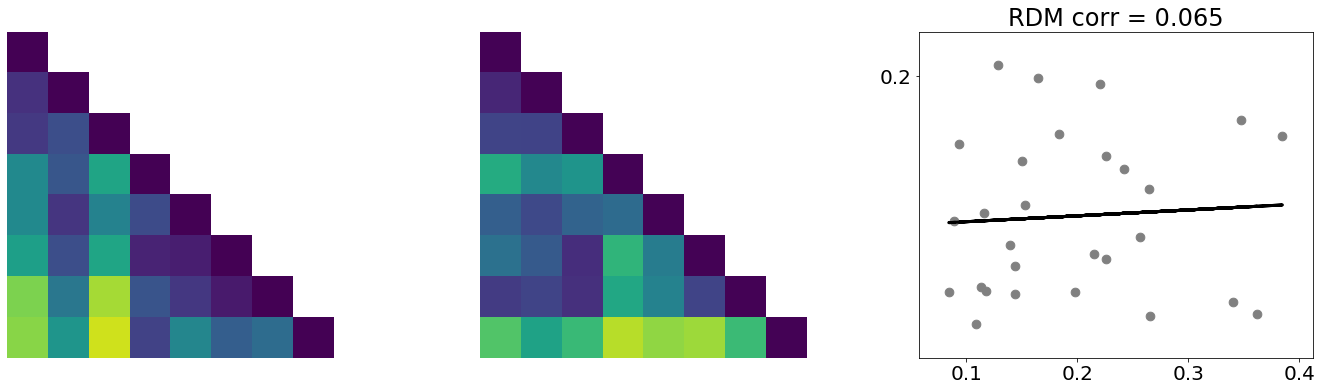

gabor


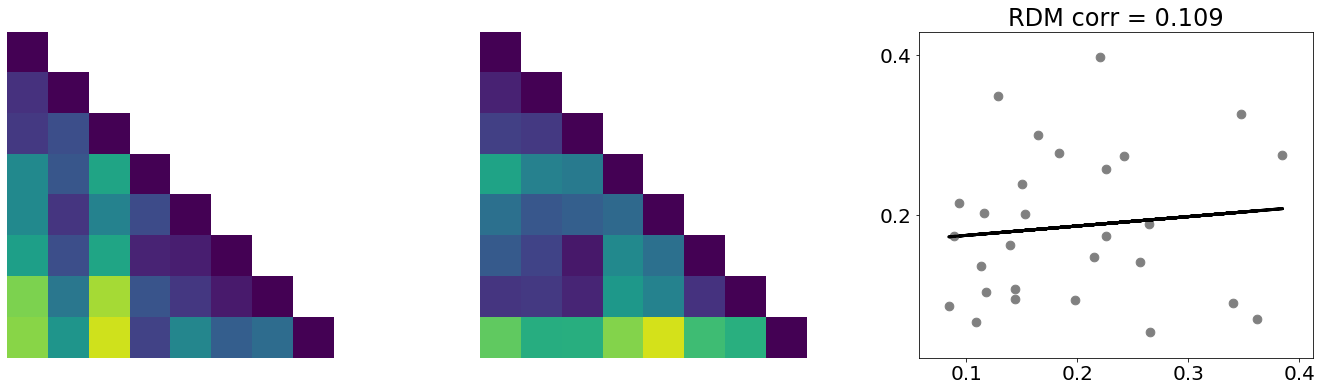

In [40]:
import math
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

plt.rcParams.update({'font.size': 20})

# plot 3: brain-model RDM corrs

for roi in opts['regions']:
    
    neural_rdv = R['neural'][roi]['rdv']['categ']
    
    modality = 'deepnet'
    
    for mdl in corrs[roi]['varpartition']['predictor_strs']:
        if 'gist' in mdl:
            modality = 'imgstats'
        print(mdl)
            
        deepnet_rdv = R[modality][mdl]['rdv']['categ']

        plt.figure(figsize=(24,6))
        plt.subplot(131)
        plot_RDM(neural_rdv)
        
        plt.subplot(132)
        plot_RDM(deepnet_rdv)
        
        plt.subplot(133)
        #sns.scatterplot(neural_rdv,deepnet_rdv,s=100)
        plt.scatter(neural_rdv,deepnet_rdv,75,color='gray')
        b, m = polyfit(neural_rdv,deepnet_rdv, 1)
        
        r = rsa.rdvcorr(neural_rdv,deepnet_rdv)

        plt.plot(neural_rdv, b + m * neural_rdv, '-', lw = 3, color = 'k')
        plt.title('RDM corr = %.3f' % (r))
        plt.xticks(np.arange(round_down(min(neural_rdv),1), round_up(max(neural_rdv),1) + 0.05, 0.1))
        plt.yticks(np.arange(round_down(min(deepnet_rdv),1), round_up(max(deepnet_rdv),1) + 0.05, 0.2))
        plt.axis('tight')

        plt.show()


In [41]:
def mds_helper(coords, colors = categ_colors, lims = 0.9, size=75):
    for i in range(coords.shape[0]):
        idx = np.floor(i/30)
        col = np.array(colors[int(idx),:]).reshape(1,3)
        plt.scatter(coords[i,0],coords[i,1],size,c=col,alpha=0.85)

        plt.xlim([-lims,lims])
        plt.ylim([-lims,lims])
        plt.box(False)
    

object_dnFA_17_relu6


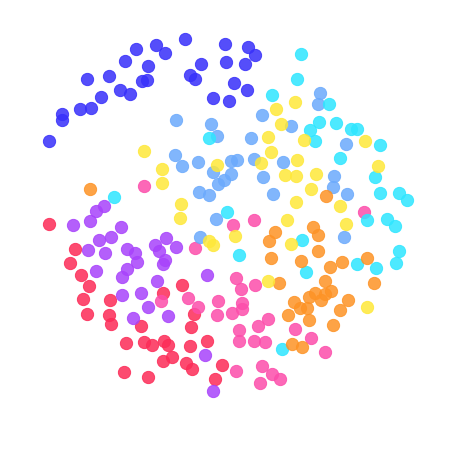

face_dnFA_17_relu6


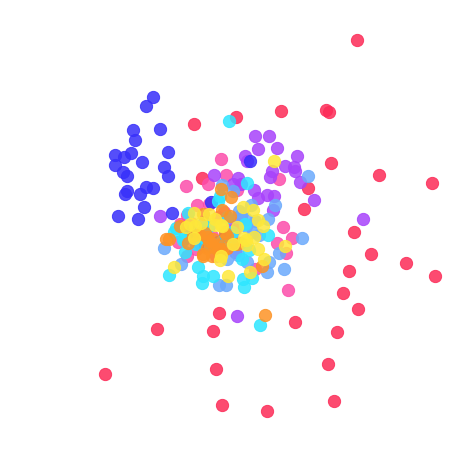

face_layer_17_relu6


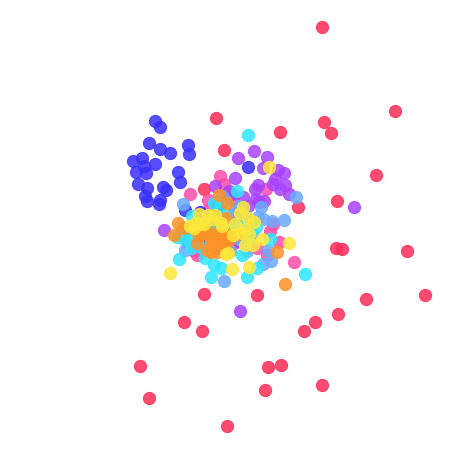

object_dnPA_20_relu7


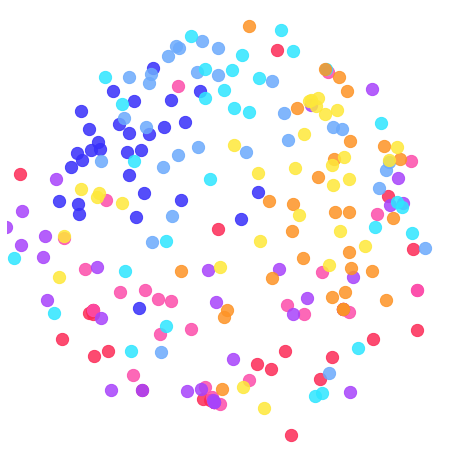

scene_dnPA_17_relu6


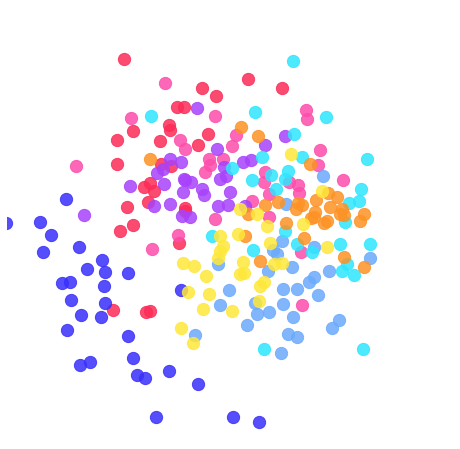

scene_layer_12_relu5


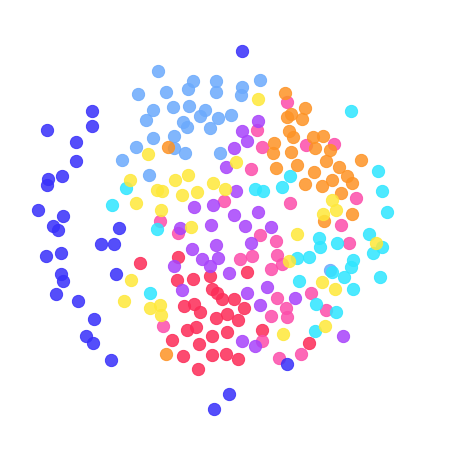

random_dnPA_2_relu1


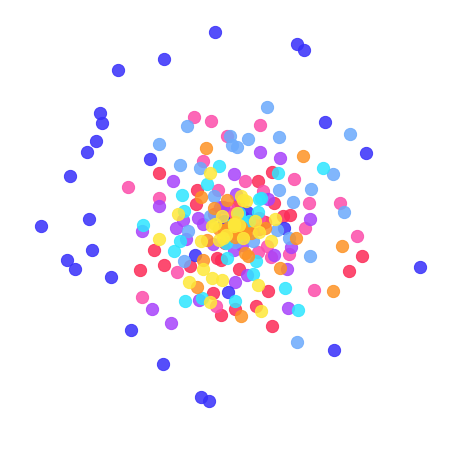

random_layer_2_relu1


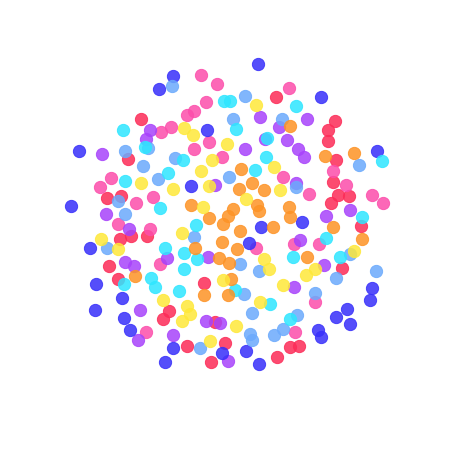

In [42]:
# plot 4: best model MDS

for roi in opts['regions']:
        
    modality = 'deepnet'
    
    for mdl in corrs[roi]['varpartition']['predictor_strs']:
        if 'gist' in mdl or 'gabor' in mdl:
            continue
            
        print(mdl)
        
        plt.figure(figsize=(8,8))

        mds_coords = R[modality][mdl]['mds']['item']
        mds_helper(mds_coords,size=150)
        plt.axis('off')
        plt.xlim([-0.9,0.9])
        plt.ylim([-0.9,0.9])
        plt.show()

In [43]:
# plot 5: variance partition for each region

FFA


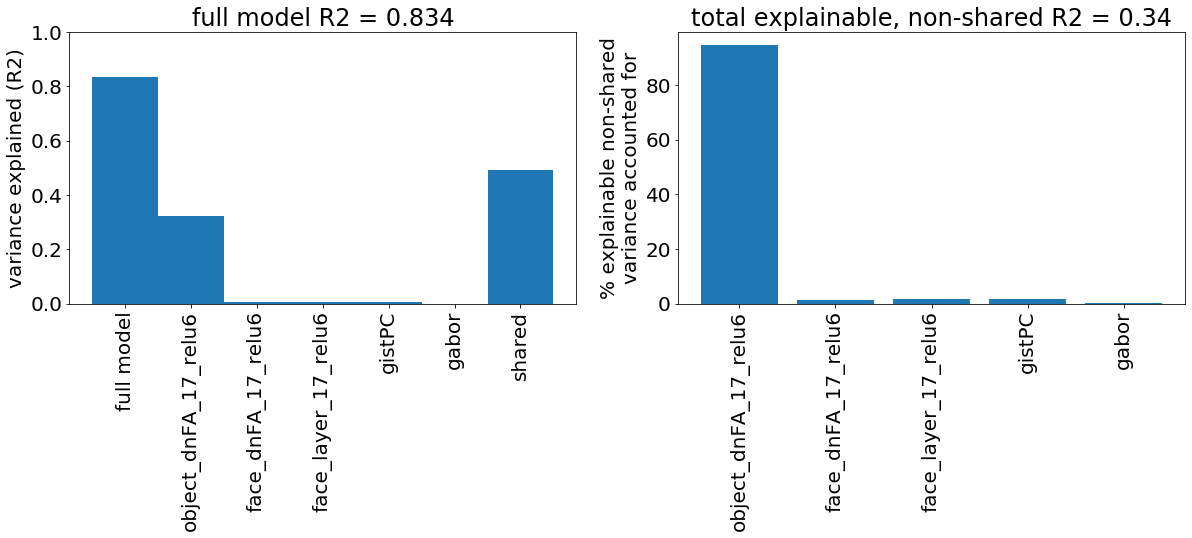

PPA


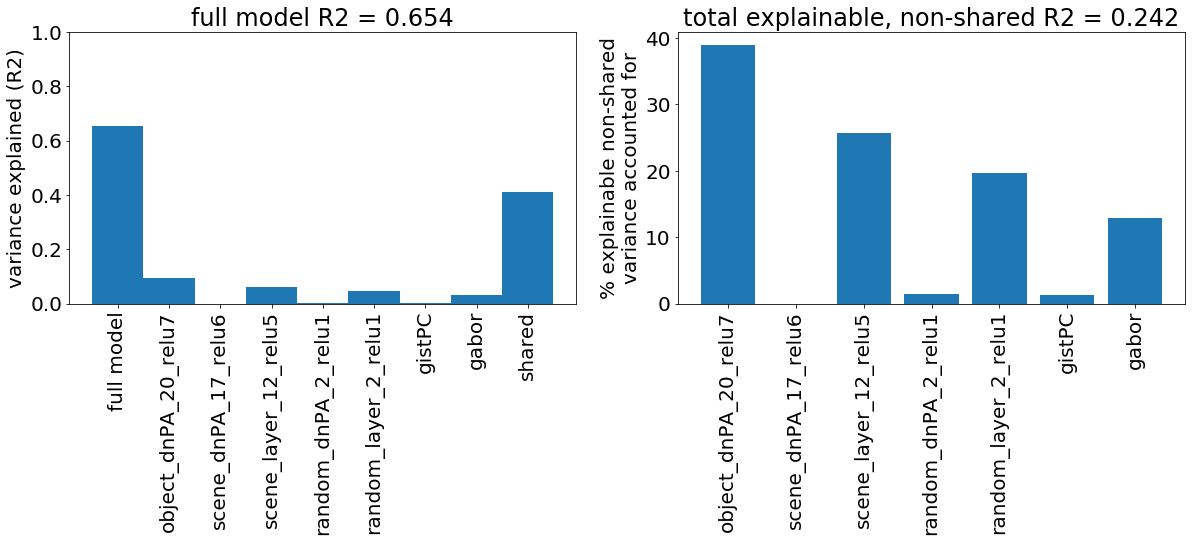

In [44]:
for brain_roi in opts['regions']:
    print(brain_roi)
    #sns.set_style("whitegrid")
    full_R2 = corrs[brain_roi]['varpartition']['full_R2'] 
    unique_vars = corrs[brain_roi]['varpartition']['unique']
    shared = corrs[brain_roi]['varpartition']['shared']
    predictor_strs = corrs[brain_roi]['varpartition']['predictor_strs']
    non_explained = corrs[brain_roi]['varpartition']['non_explained']
    
    explained_nonshared = full_R2 - shared
    data = np.array(unique_vars) / explained_nonshared * 100
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    data_ = [full_R2] + unique_vars + [shared]
    plt.bar(np.arange(len(data_)),data_,width=1)
    plt.xticks(np.arange(len(data_)), np.array(['full model'] + predictor_strs + ['shared']),rotation=90)
    plt.ylabel('variance explained (R2)')
    plt.axis('tight')
    plt.ylim([0, 1])
    plt.title(f'full model R2 = {round(full_R2,3)}')
    
    
    plt.subplot(122)
    data_ = data
    plt.bar(np.arange(len(data_)),data_)
    plt.ylim([0, 100])
    plt.xticks(np.arange(len(data)), np.array(predictor_strs),rotation=90)
    plt.ylabel('% explainable non-shared\nvariance accounted for')
    plt.axis('tight')
    plt.title(f'total explainable, non-shared R2 = {round(explained_nonshared,3)}')
    
    plt.show()
    

['object_dnPA_20_relu7', 'scene_dnPA_17_relu6', 'scene_layer_12_relu5', 'random_dnPA_2_relu1', 'random_layer_2_relu1', 'gistPC', 'gabor', 'shared'] [9.42040337e-02 2.34985248e-05 6.22307869e-02 3.40364160e-03
 4.75916164e-02 3.23502958e-03 3.12041098e-02 4.12418518e-01]
1.0
1.0
[0.34568876526947945, 0.2418927165161292, 0.41241851821439135] [0.34568876526947945, 0.09420403368187913, 2.3498524842957558e-05, 0.06223078693488915, 0.003403641598171636, 0.047591616394172975, 0.0032350295797155537, 0.031204109802457802, 0.41241851821439135] ['object_dnPA_20_relu7', 'scene_dnPA_17_relu6', 'scene_layer_12_relu5', 'random_dnPA_2_relu1', 'random_layer_2_relu1', 'gistPC', 'gabor']


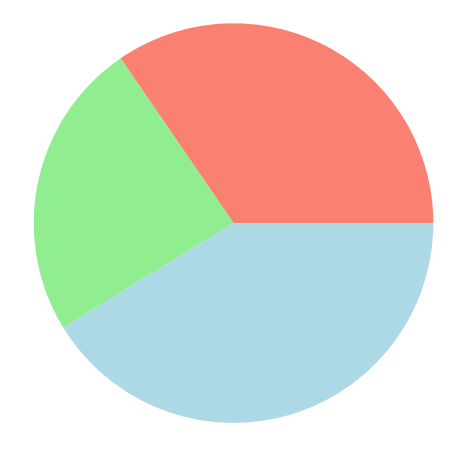

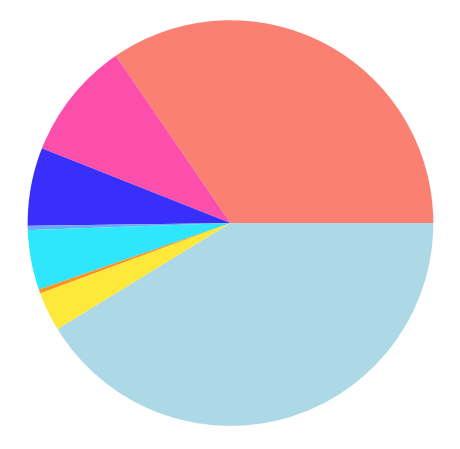

In [45]:
labels = predictor_strs + ['shared']
sizes = np.array(unique_vars + [shared])
print(labels,sizes)
#explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# plt.figure(figsize=(8,8))
# plt.pie(sizes,colors=categ_colors[1:])#, autopct='%1.1f%%',
#         #shadow=True, startangle=90)
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.show()

# print(np.round(sizes,3))

a = [non_explained, full_R2-shared, shared]
print(sum(a))
plt.figure(figsize=(8,8))
plt.pie(a,colors=['salmon','lightgreen','lightblue'])
plt.axis('equal')

b = [non_explained] + list(unique_vars) +[shared]
print(sum(b))
plt.figure(figsize=(8,8))
plt.pie(b,colors=['salmon'] + list(categ_colors[1:]) +['lightblue'])
plt.axis('equal')


print(a,b,predictor_strs)

In [46]:
# plot 6: layer summaries of brain-model RDM corrs  

FFA
PPA


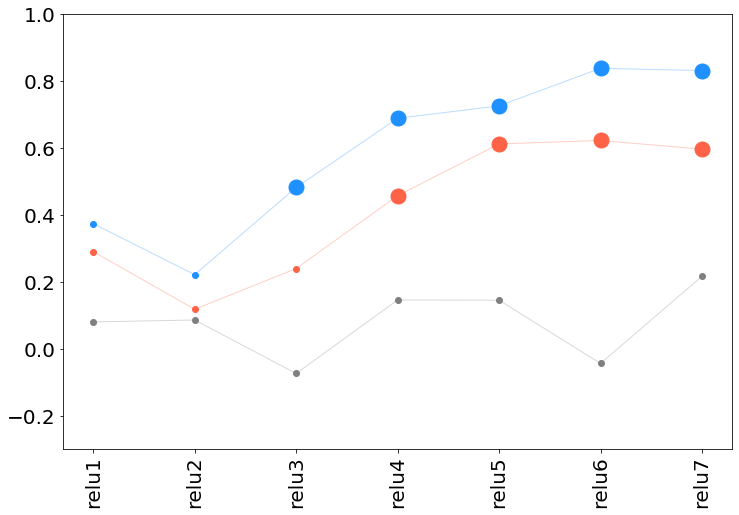

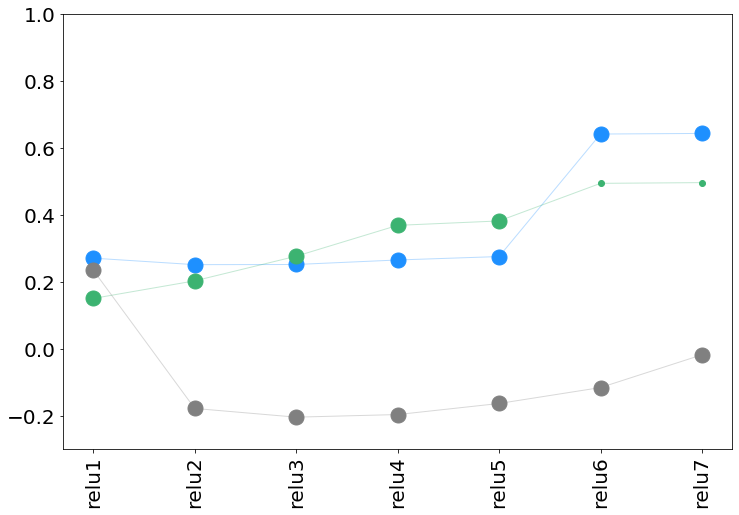

In [47]:
layer_strs = [x.split('_')[1] for x in layers]

relevant_models = dict()
relevant_models['FFA'] = ['object_dnFA', 'face_layer', 'random_dnFA']
relevant_models['PPA'] = ['object_dnPA', 'scene_layer', 'random_dnPA']

colors = dict()
colors['FFA'] = ['dodgerblue','tomato','gray']
colors['PPA'] = ['dodgerblue','mediumseagreen','gray']

scheme = 1

for brain_roi in opts['regions']:
    print(brain_roi)
    #sns.set_style("whitegrid")
    plt.figure(figsize=(12,8))
    c = 0
    for model in relevant_models[brain_roi]:
        val = validity[brain_roi][model]['isvalid']
        
        if scheme == 1:
            for ii in range(len(val)):
                if val[ii] == 1:
                    markersize=30
                else:
                    markersize=12
                if c == 0:
                    pass
                    #plt.plot(ii,corrs[brain_roi][model][ii],color=colors[brain_roi][c+1],marker='.',markersize=markersize+7)
                plt.plot(ii,corrs[brain_roi][model][ii],color=colors[brain_roi][c],marker='.',markersize=markersize)

            plt.plot(corrs[brain_roi][model],color=colors[brain_roi][c],alpha=0.3,label=model,linewidth=1)
        elif scheme == 2:
            plt.plot(corrs[brain_roi][model],color=colors[brain_roi][c],alpha=1,label=model,linewidth=4)
            
        c+=1
    #plt.legend()
    plt.xticks(np.arange(len(corrs[brain_roi][model])),np.array(layer_strs),rotation=90)
    plt.ylim([-0.3,1])
    

In [48]:
# plot 7: layer summaries of MDS

['2_relu1', '5_relu2', '8_relu3', '10_relu4', '12_relu5', '17_relu6', '20_relu7']
object_dnFA


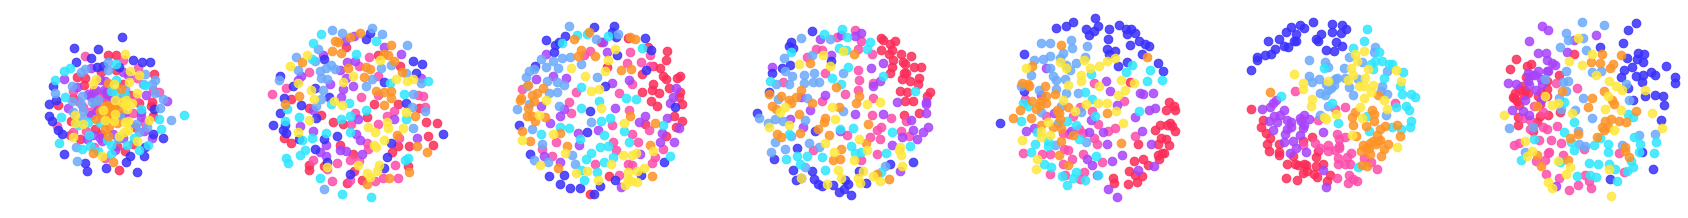

face_layer


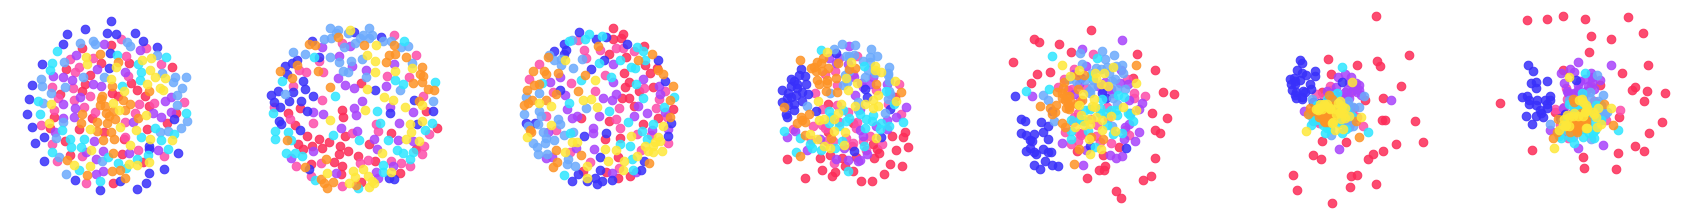

random_dnFA


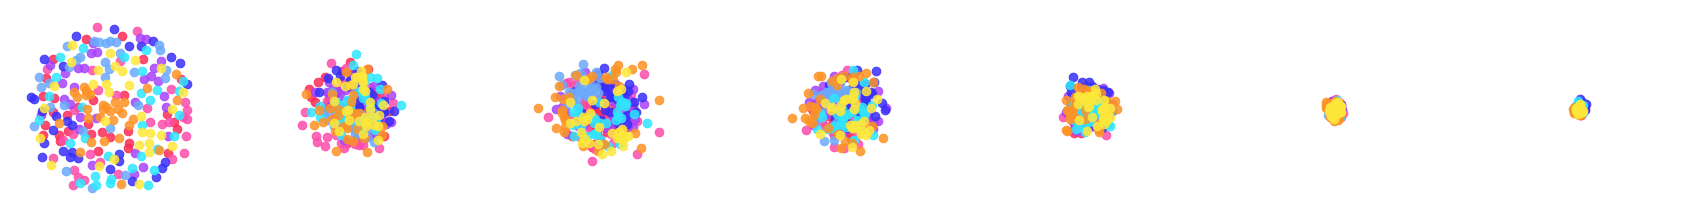

object_dnPA


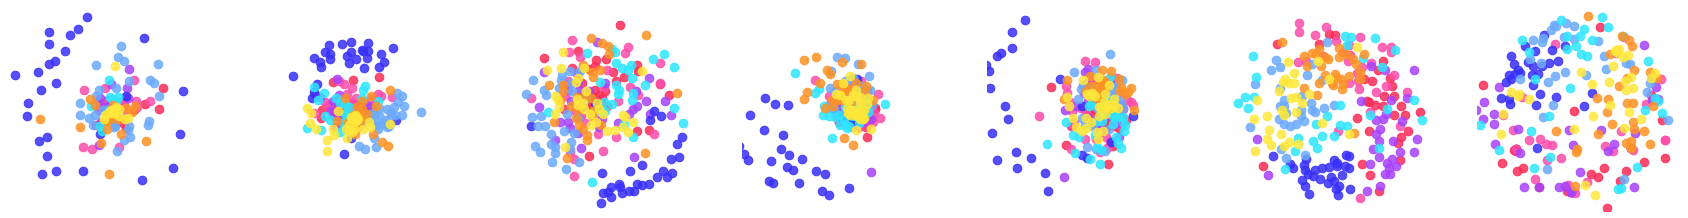

scene_layer


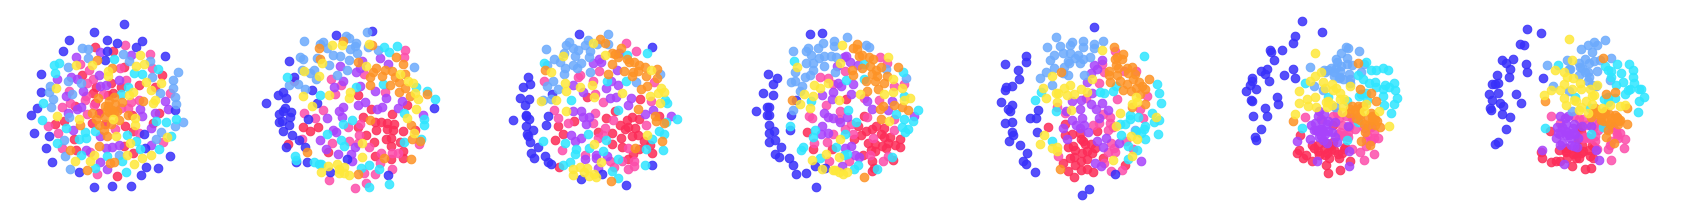

random_dnPA


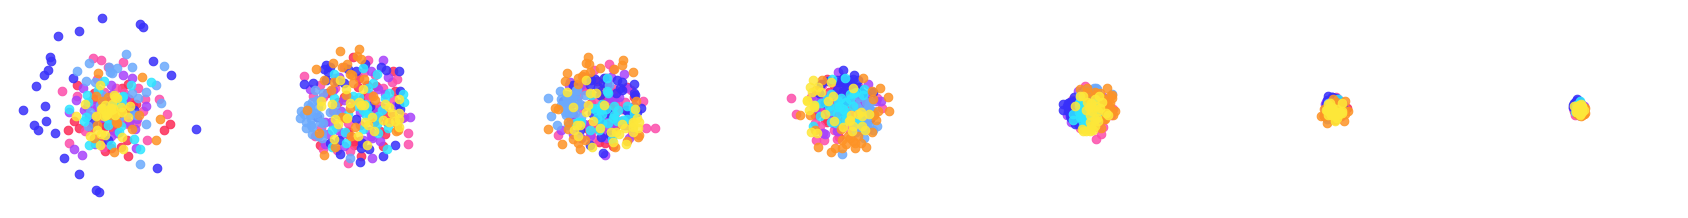

In [52]:
plot_layers = 'r' # c for convs and fcs, relu for relus
lim = 0.9

lays = [x for x in layers if plot_layers in x]
print(lays)

for roi in opts['regions']:
    for mdl in relevant_models[roi]:
        print(mdl)
        c=1
        plt.figure(figsize=(30,5))
        for i in range(len(lays)):
            plt.subplot(1,len(lays),c)
            mds_helper(R['deepnet'][f'{mdl}_{lays[i]}']['mds']['item'],size=75)
            c+=1
            plt.axis('square')
            plt.xlim([-lim,lim])
            plt.ylim([-lim,lim])
            plt.axis('off')
        plt.show()
        
        

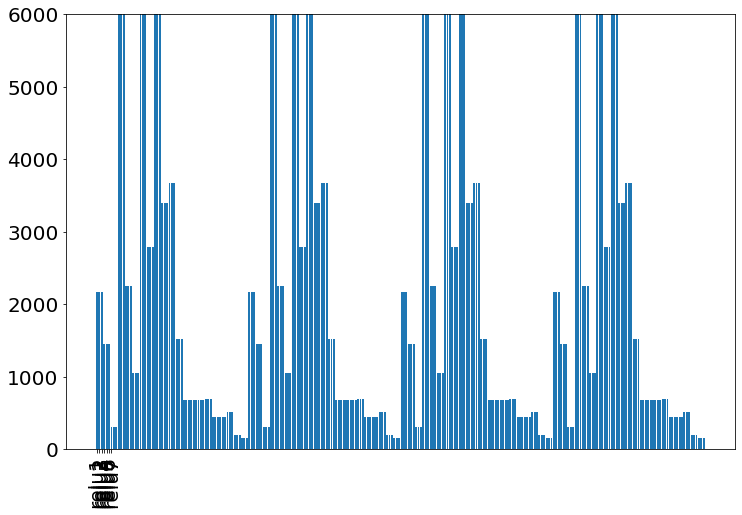

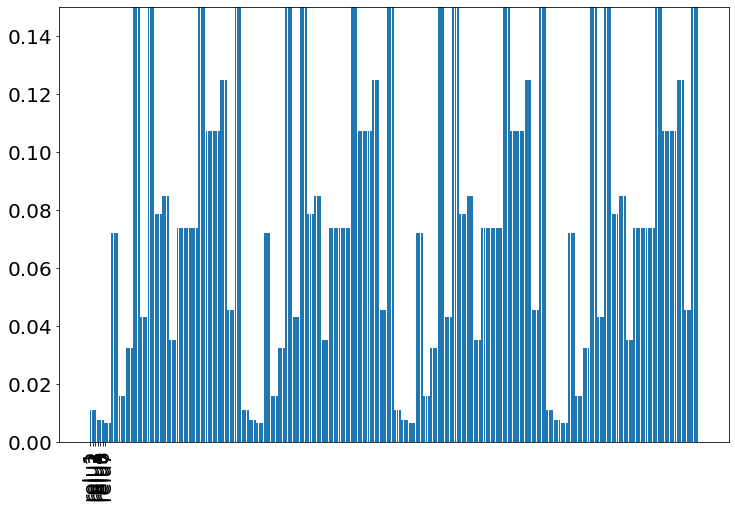

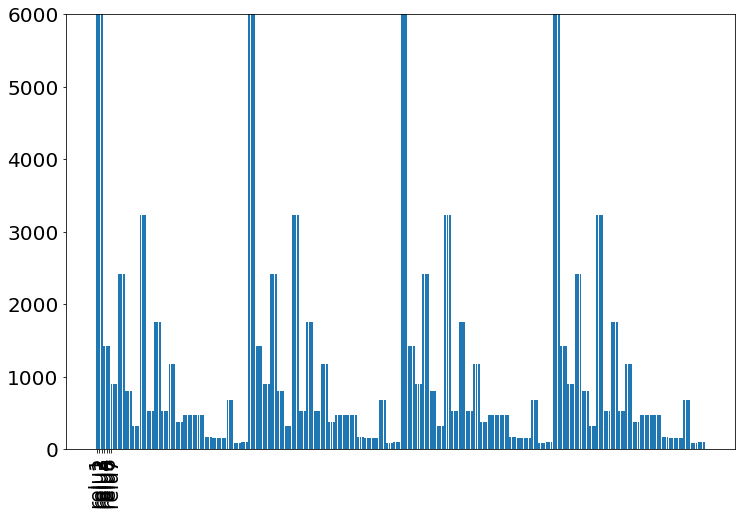

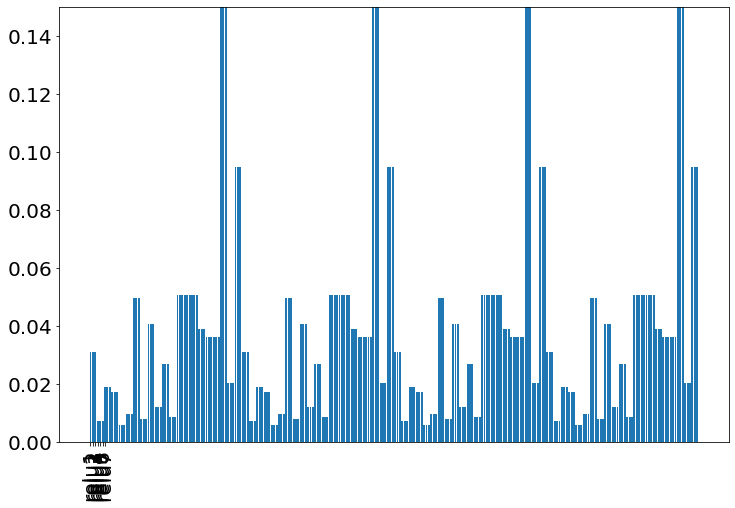

In [53]:
for a in ['dnFA','dnPA']:  
    
    layer_sizes = []
    layer_props = []

    for layer in all_layers:

        layer_sizes.append(R['deepnet'][f'object_{a}_{layer}']['n_selective'])
        layer_props.append(R['deepnet'][f'object_{a}_{layer}']['prop_selective'])

    plt.figure(figsize=(12,8))
    plt.bar(np.arange(len(layer_sizes)), layer_sizes)
    plt.xticks(np.arange(len(corrs[brain_roi][model])),np.array(layer_strs),rotation=90);
    plt.ylim([0, 6000])

    plt.figure(figsize=(12,8))
    plt.bar(np.arange(len(layer_sizes)), layer_props)
    plt.xticks(np.arange(len(corrs[brain_roi][model])),np.array(layer_strs),rotation=90);

    plt.ylim([0,0.15])
    

In [ ]:
# lesioning hyperparams



In [ ]:
# plot 8: readout effect in object trained network with face and random lesions

In [ ]:

for d in ['Faces','Scenes']:
    for rand in [False,True]:
        subset_by = 1
        lesioning_method = 'sledgehammer' # sledgehammer, cascade-forward, cascade-backward, single-layer
        randomize_lesions = rand
        target_layer = 'conv3'
        lesion_domain = d
        network = 'alexnet-object'

        if lesioning_method == 'sledgehammer':
            target_str = ''
        else:
            target_str = '_target-' + target_layer

        FDR_str = str(FDR_p).replace('.','_')

        lesion_resultsdir = join(home_dir,'data','d02_modeling','lesioning',network,loc_imageset)

        results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-{lesion_domain}'

        fn = join(lesion_resultsdir,results_str + '.npy')

        results = np.load(fn,allow_pickle=True).item()

        lay_list = list(results['no_lesion']['selective_unit_acts'][d].keys())

        idx = np.argmax(results[lesion_domain]['readout_effect_corrs'])

        print(lay_list[idx])

        acts = results['no_lesion']['selective_unit_acts'][d][lay_list[idx]]

        costs = results['no_lesion']['accuracies'] - results[d]['accuracies']

        jitter = np.random.normal(0,0.015,len(acts))

        sort_idx = np.argsort(acts)
        sort_idx_ = np.argsort(costs)

        acts = acts + jitter*2
        costs = costs + jitter

        plt.figure(figsize=(24,6))
        
        a = 0.8
        s = 10
        
        colors = np.array(['r'] * 398 + ['b'] * (1000 - 398))

        for i in range(1000):
            plt.subplot(131)
            plt.plot(i,acts[sort_idx[i]],marker='.',color=colors[sort_idx][i],markersize=s,alpha=a)
            plt.subplot(132)
            plt.plot(i,costs[sort_idx_[i]],marker='.',color=colors[sort_idx_][i],markersize=s,alpha=a)

        plt.subplot(131)
        plt.ylim([0,3.6])
        plt.subplot(132)
        plt.ylim([-0.3,0.9])
        plt.subplot(133)
        plt.scatter(acts[:398],costs[:398],c='r',alpha=a,s=s)
        plt.scatter(acts[398:],costs[398:],c='b',alpha=a,s=s)

        b, m = polyfit(acts,costs, 1)

        r = np.corrcoef(acts,costs)[1,0]

        plt.plot(acts, b + m * acts, '-', lw = 4, color = 'k')
        plt.title('corr = %.3f' % (r))

        plt.axis('tight')
        plt.show()

In [ ]:
# plot 9: layer summary of readout effect (sledgehammer)

In [ ]:
colors = [['red','lightcoral'], ['dodgerblue','lightskyblue']]
b = 0
lesioning_method = 'sledgehammer'
if lesioning_method == 'sledgehammer':
    target_str = ''
else:
    target_str = '_target-' + target_layer
    
for d in ['Faces','Scenes']:
    plt.figure(figsize=(12,8))
    c = 0
    for rand in [False,True]:
        randomize_lesions = rand
        lesion_domain = d

        lesion_resultsdir = join(home_dir,'data','d02_modeling','lesioning',network,loc_imageset)
        results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-{lesion_domain}'

        fn = join(lesion_resultsdir,results_str + '.npy')
        results = np.load(fn,allow_pickle=True).item()

        lay_list = list(results['no_lesion']['selective_unit_acts'][d].keys())

        layer_readout_effects = results[lesion_domain]['readout_effect_corrs'][:-1]
        plt.plot(layer_readout_effects,color=colors[b][c],linewidth=2)
        plt.xticks(np.arange(len(lay_list))[:-1],np.array(lay_list)[:-1],rotation=90)
        c+=1
    plt.ylim([-0.1,0.8])
    plt.show()
    b+=1


In [ ]:
# plot 9: layer summary of readout effect (single layer lesions)

In [ ]:
colors = [['red','lightcoral'], ['dodgerblue','lightskyblue']]
lesioning_method = 'single-layer'
b = 0
for d in ['Faces','Scenes']:
    plt.figure(figsize=(12,8))
    c = 0
    for rand in [False,True]:
        randomize_lesions = rand
        lesion_domain = d

        readout_corrs = []
        l = 0
        for lay in lay_list[:-1]:

            target_str = '_target-' + lay

            results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-{d}'

            fn = join(lesion_resultsdir,results_str + '.npy')
            results = np.load(fn,allow_pickle=True).item()
            readout_corrs.append(results[d]['readout_effect_corrs'][l])
            l+=1
        plt.plot(readout_corrs,color=colors[b][c],linewidth=2)
        plt.xticks(np.arange(len(lay_list))[:-1],np.array(lay_list)[:-1],rotation=90)
        c+=1
    plt.ylim([-0.1,0.8])
    plt.show()
    b+=1


In [ ]:
# plot 10: which categories are most (and least) impaired by lesioning?

In [ ]:
def add_border(pil_img, width, color):
    im = val_dataset_[img_rankings_flipped[i]][0]

    a = np.array(pil_img)

    for x in range(width):
        for y in range(a.shape[0]):
            a[x, y, :] = color
            a[112-x-1, y, :] = color
            a[y, x, :] = color
            a[y, 112-x-1, :] = color

    im = Image.fromarray(a.astype('uint8'), 'RGB')
    
    return im


In [ ]:
table = pd.read_csv('/home/jacobpri/git/RotspaceIT/data/d02_modeling/metadata/imagenet_class_labels_1000.csv',header=None)
labels_ = table.iloc[:,0]
labels_ = labels_.to_numpy()
labels = []

for label in labels_:
    labels.append(label.split(': ')[1].split(',')[0].lower().strip("'"))
    
print(labels[:10])

In [ ]:
red = np.array([233,96,96])
blue = np.array([50,130,249])

width = 7

imageset_dir = join(home_dir,'imagesets','localizer',loc_imageset)
assert(exists(imageset_dir))

val_imageset_dir = '/lab_data/tarrlab/common/datasets/ILSVRC/Data/CLS-LOC/val/'
assert(exists(val_imageset_dir))

data_transform_ = transforms.Compose([       
transforms.Resize(112),                   
transforms.CenterCrop((112,112))])

val_dataset_ =  datasets.ImageFolder(root = val_imageset_dir, transform = data_transform_)

for lesion_domain in ['Faces','Scenes']:

    for lesioning_method in ['sledgehammer']:#,'cascade-forward','cascade-backward','single-layer']:
        for randomize_lesions in [False,True]:
            
            print(lesion_domain, lesioning_method, randomize_lesions)

            if lesioning_method == 'sledgehammer':
                target_str = ''
            else:
                target_str = '_target-' + lay

            results_str = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-{lesion_domain}'

            fn = join(lesion_resultsdir,results_str + '.npy')

            try:
                results = np.load(fn,allow_pickle=True).item()

                costs = results['no_lesion']['accuracies'] - results[lesion_domain]['accuracies']

                rankings = np.flip(np.argsort(costs))

                results[lesion_domain]['cost_rankings'] = rankings

                plot_rankings = copy.deepcopy(rankings)
                img_rankings = copy.deepcopy(rankings)
                for r in range(len(rankings)):
                    img_rankings[r] = rankings[r] * 50 + 5
               
                p = 25
                plt.figure(figsize=(12,12))
                c = 1
                for i in range(p):
                    plt.subplot(5,5,c)
                    im = val_dataset_[img_rankings[i]][0]
                    if rankings[i] < 398:
                        col = red
                    else:
                        col = blue
                    plt.imshow(add_border(im,width,col))
                    plt.xticks([])
                    plt.yticks([])
                    plt.axis('tight')
                    plt.title(f'{labels[rankings[i]]}',fontsize=12)
                    
                    ax = plt.gca()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
                    c += 1
                plt.show()
                
                plt.figure(figsize=(12,12))
                c = 1
                img_rankings_flipped = np.flip(copy.deepcopy(img_rankings))
                p = 25
                for i in range(p):
                    plt.subplot(5,5,c)
                    im = val_dataset_[img_rankings_flipped[i]][0]
                    if np.flip(rankings)[i] < 398:
                        col = red
                    else:
                        col = blue
                    plt.imshow(add_border(im,width,col))
                    plt.xticks([])
                    plt.yticks([])
                    plt.axis('tight')
                    plt.title(f'{labels[np.flip(rankings)[i]]}',fontsize=12)
                    ax = plt.gca()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
                    c += 1
                plt.show()
            except:
                print('ah')
                pass


In [ ]:
# plot 11, are the categs hurt by face/scene lesioning correlated?

In [ ]:
a = 0.8
s = 10

for lesioning_method in ['sledgehammer']:
    for randomize_lesions in [False, True]:
        
        plt.figure(figsize=(24,6))

        fs_cost_corrs = []

        if lesioning_method == 'sledgehammer':
            target_str = ''
        else:
            target_str = '_target-' + lay

        results_str_faces = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-Faces'
        results_str_scenes = f'LesionResults_dim-{img_dim}_FDR-{FDR_str}_subset-{subset_by}_method-{lesioning_method}_random-{str(randomize_lesions)}{target_str}_domain-Scenes'

        plt.subplot(131)
        
        fn = join(lesion_resultsdir,results_str_faces + '.npy')
        results = np.load(fn,allow_pickle=True).item()
        
        x = results['no_lesion']['accuracies']
        jitter = np.random.normal(0,0.005,len(x))
        x = x + jitter
        y = results['Faces']['accuracies']
        jitter = np.random.normal(0,0.005,len(x))
        y = y + jitter
        
        plt.scatter(x[:398], y[:398], c = 'r', alpha = a, s=s)
        plt.scatter(x[398:], y[398:], c = 'b', alpha = a, s=s)
        
        plt.plot(np.arange(0,2,0.1), np.arange(0,2,0.1),'k--',linewidth=3) 
        
        plt.axis('square')
        plt.xlim([0,1])
        plt.ylim([0,1])
        
        face_cost = results['no_lesion']['accuracies'] - results['Faces']['accuracies'] - jitter

        plt.subplot(132)
        
        fn = join(lesion_resultsdir,results_str_scenes + '.npy')
        results = np.load(fn,allow_pickle=True).item()
        
        x = results['no_lesion']['accuracies']
        jitter = np.random.normal(0,0.005,len(x))
        x = x + jitter
        y = results['Scenes']['accuracies']
        jitter = np.random.normal(0,0.005,len(x))
        y = y + jitter
        
        plt.scatter(x[:398], y[:398], c = 'r', alpha = a, s=s)
        plt.scatter(x[398:], y[398:], c = 'b', alpha = a, s=s)
        
        plt.plot(np.arange(0,2,0.1), np.arange(0,2,0.1),'k--',linewidth=3) 
        
        plt.axis('square')
        plt.xlim([0,1])
        plt.ylim([0,1])
        
        scene_cost = results['no_lesion']['accuracies'] - results['Scenes']['accuracies'] + jitter 

        fs_cost_corrs = np.corrcoef(face_cost,scene_cost)[1,0]
                
        plt.subplot(133)
        plt.scatter(face_cost[:398],scene_cost[:398],c='r',alpha=a,s=s)
        plt.scatter(face_cost[398:],scene_cost[398:],c='b',alpha=a,s=s)

        b, m = polyfit(face_cost,scene_cost, 1)

        r = np.corrcoef(face_cost,scene_cost)[1,0]

        plt.plot(face_cost, b + m * face_cost, '-', lw = 4, color = 'k')
        plt.title('corr = %.3f' % (r))

        plt.axis('tight')
        plt.show()

In [ ]:
lw = 0.5
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.plot(np.arange(398),acts[:398],'r',linewidth=lw)
plt.plot(np.arange(398,1000),acts[398:],'b',linewidth=lw)
plt.subplot(132)
plt.plot(np.arange(398),costs[:398],'r',linewidth=lw)
plt.plot(np.arange(398,1000),costs[398:],'b',linewidth=lw)
plt.subplot(133)
plt.scatter(acts[:398],costs[:398],c='r')
plt.scatter(acts[398:],costs[398:],c='b')

sort_idx = np.argsort(acts)

plt.figure(figsize=(24,6))

for i in range(1000):
    plt.subplot(131)
    plt.plot(i,acts[sort_idx[i]],marker='.',color=colors[sort_idx][i],markersize=15,alpha=0.6)
    plt.subplot(132)
    plt.plot(i,costs[sort_idx[i]],marker='.',color=colors[sort_idx][i],markersize=5)
    
plt.subplot(131)
plt.plot(acts[sort_idx],color='gray',alpha=0.5,linewidth=0.5)
plt.subplot(132)
plt.plot(costs[sort_idx],color='gray',alpha=0.5,linewidth=0.5)
plt.subplot(133)
plt.scatter(acts[:398],costs[:398],c='r',alpha=0.6,s=15)
plt.scatter(acts[398:],costs[398:],c='b',alpha=0.6,s=15)
# for lay in lay_list:
#     selective_unit_acts = results['no_lesion']['selective_unit_acts']['Faces'][lay]
#     plt.figure()
#     plt.plot(selective_unit_acts)


In [ ]:
# modality -> region -> datatype -> level 
# brain -> FFA -> univar -> categ
# deepnet -> obj_dnFA_conv5 -> rdv -> categ
# deepnet -> face_dnFA_fc6

In [ ]:
#print(R['deepnet'].keys())
plt.plot(R['deepnet']['object_dnPA_16_fc6']['univar']['item'])

In [ ]:
plt.figure(figsize=(24,8))
rsa.dm_corr_scatter([R['neural']['FFA']['rdv']['categ'],
                     R['deepnet']['face_dnFA_17_relu6']['rdv']['categ']])

In [ ]:
mds_coords = R['deepnet']['object_dnFA_17_relu6']['mds']['item']
plt.figure()
for i in range(8):
    idx = np.arange(30*i,30*i+30)
    plt.scatter(mds_coords[idx,0],mds_coords[idx,1])


In [ ]:
# load gist and gabor features, compute RDVs and add to dict


In [ ]:
# target directory for saving layer-wise pref dicts
gist_savedir = join(home_dir,'data','d02_modeling','gist', 'experimental', imageset)

## load preference dict for a given locset/model/param combination
load_strs = ['GistPCFeatures.mat','GaborFeatures.mat']

R['imgstats'] = dict()
R['imgstats']['gistPC'] = dict()
R['imgstats']['gistPC']['rdv'] = dict()
R['imgstats']['gabor'] = dict()
R['imgstats']['gabor']['rdv'] = dict()

for load_str in load_strs:

    load_fn = join(gist_savedir,load_str)
    if not exists(load_fn):
        print(load_fn)
        raise ValueError('feature file does not exist')

    else:
        features = sio.loadmat(load_fn)[load_str.split('.')[0]]
        
        print(features.shape)
        
        if 'gist' in load_str.lower():
            R['imgstats']['gistPC']['rdv']['item'] = rsa.rdv(features, rdv_dist)
            R['imgstats']['gistPC']['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(features, opts['categ_idx']), rdv_dist)
        elif 'gabor' in load_str.lower():
            R['imgstats']['gabor']['rdv']['item'] = rsa.rdv(features, rdv_dist)
            R['imgstats']['gabor']['rdv']['categ'] = rsa.rdv(rsa.collapse_categs(features, opts['categ_idx']), rdv_dist)

In [ ]:
plt.figure(figsize=(24,8))
rsa.dm_corr_scatter([R['neural']['FFA']['rdv']['categ'],
                     R['imgstats']['gabor']['rdv']['categ']])

In [ ]:
plt.figure(figsize=(30,30))
rsa.plot_matrix(rsa.v2m(R['neural']['FFA']['rdv']['categ']))